<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Lab #1: ES models </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 
This is first laboratory task for the course TSA.
The Lab is desinged to impove skills of tuning parameters of ES models and get experience of coding of simple Regression Models.

The Lab should take about 5-6 hours to be completed.

<h1 align="center">Important Info</h1> 
- <span style="font-size: 14pt;"> You must send your solution to the email </span> <span style="color:red; font-size: 12pt;">alexromsput@gmail.com, </span>
- The theme of your message must be <span style="color:red; font-size: 12pt;"> TSA-Erevan-2017-[Your Surname] </span>, for exmaple -- TSA-Erevan-2017-Romanenko,
- You can send ipnb file in attachment or just a link to github. The file in attachment of the letter must be named as <span style="color:red; font-size: 12pt;"> [Surname]-[Group]-Lab1.ipnb</span>, for example -- Romanenko-Evening-Lab1.ipnb,
  
<span style="color:red; font-size: 14pt;"> DEADLINE: 10 June 2017 23:59:59 </span>


<h1 align="center">1. Using ARIMA for wage and electricity comsumption datasets (50%)</h1>
Solve the task for Practice day 2.

In [46]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import statsmodels.api as sm
from utils import qualityMACAPE, qualityRMSE
import itertools
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image

%matplotlib inline

<h1 align="center">1. Reading data (5%)</h1>

  * Download data for following data sets
     - 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv </span>(1 TS of monthly wage in Russia)
     - 2) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_cunsumption.csv</span> (105 TS of goods sales in shop #36 of one real Retail Net, each TS correspond to an item in shop )
 
 All data you can find by <a href='https://1drv.ms/f/s!AqGgzb5T4tvShZ5by4qa_HFqAAoYIg'>link</a> 
 
 
 * For each data set: 
      - 1) learn it's structure in csv-file and read it into Pandas data frame (be careful with parsing data)
      - 2) plot each time series
      - 3) answer the questions: is there seasonlaity, trend, changes in level in TS? If there is seasonality then define period of seasonality. 

### Data reading, plotting, visual investigation

In [57]:
ts_wage = pd.read_csv('C:/Users/AM000110/Desktop/ML/TimeSeries/Practise & Lab/data/monthly-wage.csv', sep=';', decimal='.', parse_dates=True, index_col='Month')
ts_wage.index.names=['Timestamp'] # renaming
ts_wage = ts_wage.sort_index() # sorting indexes

In [58]:
ts_wage.head()

,Real wage
Timestamp,
1993-01-01,100.00
1993-02-01,99.04
1993-03-01,101.77
1993-04-01,110.05
1993-05-01,115.47


In [59]:
ts_wage.tail()

,Real wage
Timestamp,
2016-09-01,224.9
2016-10-01,223.6
2016-11-01,225.6
2016-12-01,295.3
2017-01-01,220.3


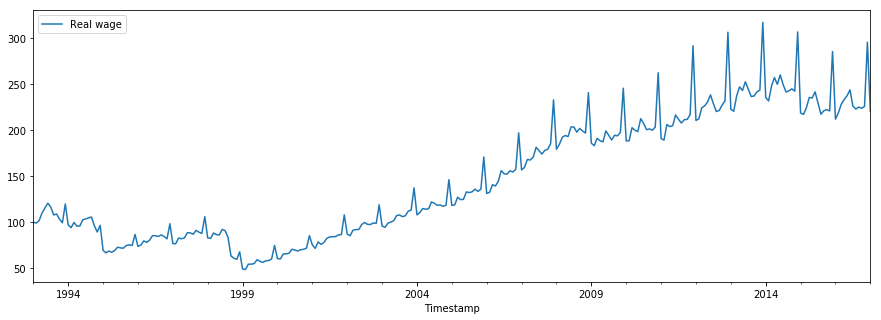

In [60]:
ts_wage.plot(figsize=(15,5))

In [61]:
ts_wage.index.size

289

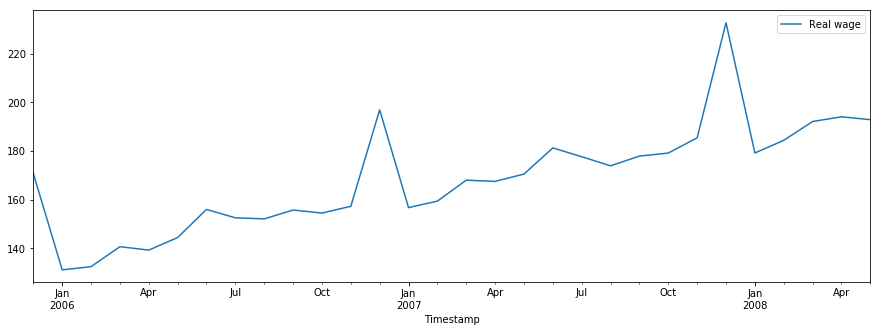

In [62]:
ts_wage.iloc[155:185].plot(figsize=(15,5))

###### From the graphs we can see that there is a seasonality  (12 monthly) and little increasing trend.

<h1 align="center">2. ARIMA Momdel for wage dataset (40%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters your self ** 
Also you can follow the next scheme:
<img src='./pic/ARMA Scheme.png'>


Notes: you need follow to the steps
 * 0) Use data before 01.02.2015 
 * 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
 * 2) Dispersion is stabilized through transformation if needed.
 * 3) If the time series is non-stationary the differentiation degrees is
chosen.
 * 4) ACF/PACF are analyzed in order to understand whether AR(p)/MA(q) and seasonal $AR(P)/MA(Q)$  may be used.
 * 5) Candidate models are trained, their AIC/AIC is compared, choose trhe best model.
 * 6) Unbiasedness, stationarity and non-autocorrelation of the residuals of the obtained model are tested; if the tests fail model modifcations are reviewed.
 * 7) Build forecasts and forecastis interval for period from 01.02.2015 to 01.01.2017
     Calculate loss MACAPE of your Forecast.
     Does the forecast look like appropriate?

### 0-2. Stationarity checking

##### Data spliting into some parts and checking mean and variance 
* if they vary a lot , it means that data is not stationary.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000245372752B0>]], dtype=object)

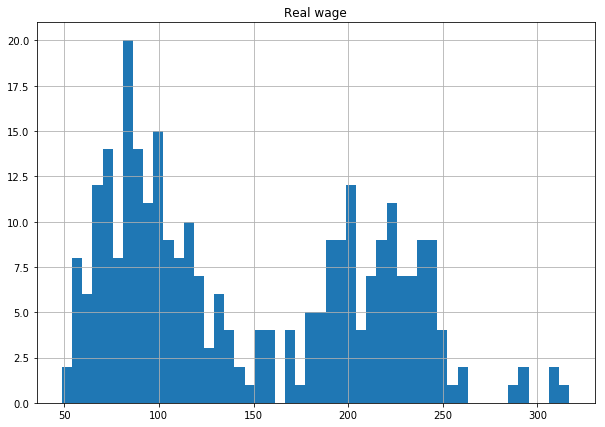

In [63]:
# First lets see the histogram of data.

ts_wage.hist(bins = 50,figsize=(10,7))

###### From the graph we can see that there is no exact distribution of data (it differs).

In [64]:
# splitting into 2 parts and calculating mean and variance

split_2 = int(ts_wage.index.size/2)

ts_1, ts_2 = ts_wage[:split_2], ts_wage[split_2:]
mean_1, mean_2 = ts_1.mean(), ts_2.mean()
var_1, var_2 = ts_1.var(), ts_2.var()

print('mean_1 = {:.2f}, mean_2 = {:.2f}'.format(float(mean_1.values), float(mean_2.values)))
print('var_1 = {:.2f}, var_2 = {:.2f}'.format(float(var_1.values), float(var_2.values)))

mean_1 = 88.22, mean_2 = 205.45
var_1 = 364.33, var_2 = 1612.54


###### We can see that variance is quite differs.

##### Statistics tests (KPSS, ADF)

* KPSS (null hypotesis is the stationarity of data: this means that if p-value is small, then most probably the data is not stationary).

In [65]:
result_KPSS = sm.tsa.kpss(np.array(ts_wage).flatten())
print('KPSS statistics = {:.2f}'.format(result_KPSS[0]))
print('KPSS p_value = {:.2f}'.format(result_KPSS[1]))

KPSS statistics = 1.63
KPSS p_value = 0.01


* ADF (null hypotesis is data non-stationarity: this means that if p-value is big, then most probably the data is not stationary).

In [66]:
results_ADF = sm.tsa.adfuller(np.array(ts_wage).flatten())
print('ADF statistics = {:.2f}'.format(results_ADF[0]))
print('ADF p_value = {:.2f}'.format(results_ADF[1]))

ADF statistics = -0.23
ADF p_value = 0.93


###### Based on both statistics test we ensure that data is not stationary.

### 3. Transforming data for stabilizing variance (box-cox, log) and differencing for making stationary.

Deleting the tail, making box-cox and logarithmic transformations

In [13]:
from copy import deepcopy

train_ts_wage = ts_wage['1999.01.01': '2015-01-01']
testing_ts_wage = ts_wage['2015-01-01':'2017-01-01']

ts_wage_trans = deepcopy(train_ts_wage) 
ts_wage_trans['Wage_boxcox'] = scipy.stats.boxcox(ts_wage_trans['Real wage'].values)[0]
ts_wage_trans['Log'] = np.log(ts_wage_trans['Real wage'])
ts_wage_trans.head(5)

,Real wage,Wage_boxcox,Log
Timestamp,,,
1999-01-01,49.22,19.998928,3.896300
1999-02-01,48.77,19.862992,3.887115
1999-03-01,54.48,21.560692,3.997834
1999-04-01,54.48,21.560692,3.997834
1999-05-01,55.13,21.750391,4.009694


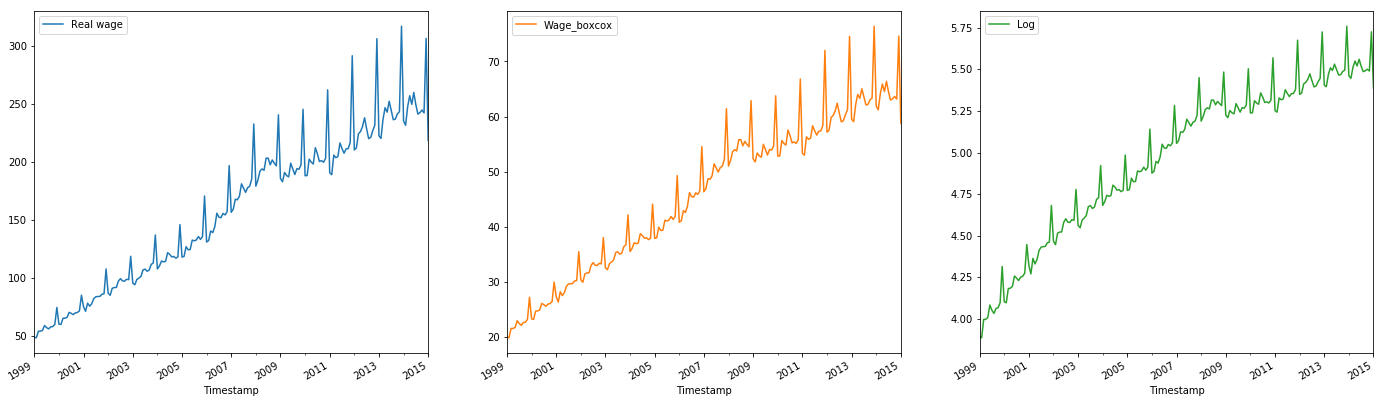

In [14]:
ts_wage_trans.plot(subplots=True, figsize=(24,7), layout=(1,3))
None

Divinding into 5 parts and calculating variance.

In [15]:
split_size = 5
split = int(ts_wage_trans.index.size/split_size - 1)

for i in range(split_size):
    print('box-cox variance_{} = {:.2f}'.format(i+1, ts_wage_trans['Wage_boxcox'][split*i:split*(i+1)].var()))
 

box-cox variance_1 = 12.33
box-cox variance_2 = 9.12
box-cox variance_3 = 26.12
box-cox variance_4 = 9.62
box-cox variance_5 = 20.96


In [16]:
for i in range(split_size):
    print('log variance_{} = {:.4f}'.format(i+1, ts_wage_trans['Log'][split*i:split*(i+1)].var()))

log variance_1 = 0.0340
log variance_2 = 0.0135
log variance_3 = 0.0228
log variance_4 = 0.0056
log variance_5 = 0.0099


###### We can see that variance is more or less stabile for box-cox transformed data. 
###### Now we will differencing it for making stationary.
1. Seasonal differencing

2. First differencing (untill data is stationarry) 

In [17]:
sp_wage = 12
ts_wage_trans_sdiff = (ts_wage_trans['Wage_boxcox'] - ts_wage_trans['Wage_boxcox'].shift(sp_wage))[sp_wage:]

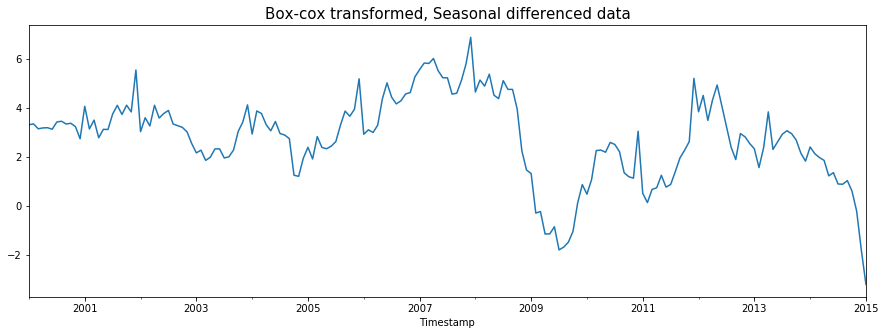

In [18]:
ts_wage_trans_sdiff.plot(figsize = (15,5))
plt.title('Box-cox transformed, Seasonal differenced data', fontsize = 15)
None

###### Visually still not stationary. We will do first differencing - 1 time. 

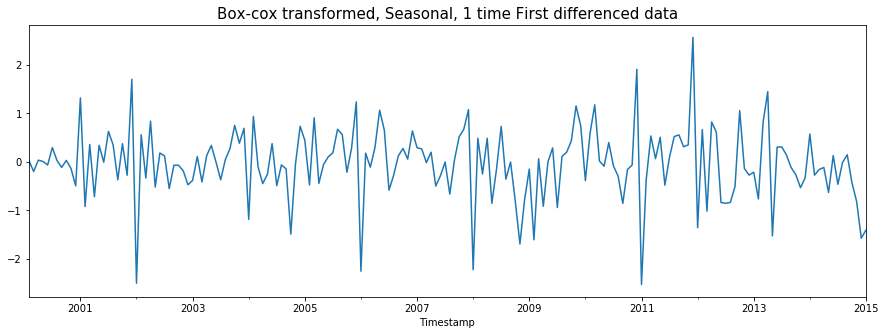

In [19]:
ts_wage_trans_sdiff_fdiff_1 = (ts_wage_trans_sdiff - ts_wage_trans_sdiff.shift(1))[1:]
ts_wage_trans_sdiff_fdiff_1.plot(figsize = (15,5))
plt.title('Box-cox transformed, Seasonal, 1 time First differenced data', fontsize = 15)
None

In [20]:
result_KPSS_trans_sd_fd_1 = sm.tsa.kpss(np.array(ts_wage_trans_sdiff_fdiff_1).flatten())
print('KPSS statistics = {:.2f}'.format(result_KPSS_trans_sd_fd_1[0]))
print('KPSS p_value = {:.2f}'.format(result_KPSS_trans_sd_fd_1[1]))

KPSS statistics = 0.15
KPSS p_value = 0.10


In [21]:
results_ADF_trans_sd_fd_1 = sm.tsa.adfuller(np.array(ts_wage_trans_sdiff_fdiff_1).flatten())
print('ADF statistics = {:.2f}'.format(results_ADF_trans_sd_fd_1[0]))
print('ADF p_value = {:.2f}'.format(results_ADF_trans_sd_fd_1[1]))

ADF statistics = -15.87
ADF p_value = 0.00


###### The data is now staionary.

### 4. ACF and PACF plots (for model selection)

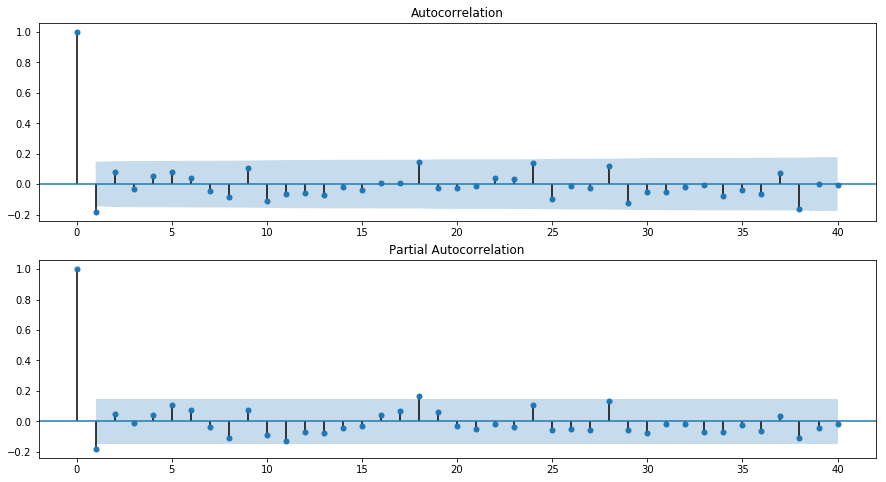

In [22]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_wage_trans_sdiff_fdiff_1.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_wage_trans_sdiff_fdiff_1.values.squeeze(), lags=40, ax=ax2)

From ACF and PACF analysis we can not suggest the appropriate AR(p) or MA(q), beacuse both (ACF and PACF) are decaying and there are no spikes in the data. We will use 2 models: simple ARIMA and SARIMAX. 

### 5. Models training

In [23]:
arima_model = sm.tsa.ARIMA(ts_wage_trans['Wage_boxcox'], order=(3,1,3))
sarimax_model = sm.tsa.SARIMAX(ts_wage_trans['Wage_boxcox'], order=(1,1,1), seasonal_order=(3,1,3,12),
                               enforce_invertibility=False)

arima_model_results = arima_model.fit()
sarimax_model_results = sarimax_model.fit()

In [24]:
print(arima_model_results.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Wage_boxcox   No. Observations:                  192
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -456.730
Method:                       css-mle   S.D. of innovations              2.553
Date:                Wed, 14 Jun 2017   AIC                            929.459
Time:                        21:01:51   BIC                            955.519
Sample:                    02-01-1999   HQIC                           940.014
                         - 01-01-2015                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2335      0.030      7.849      0.000       0.175       0.292
ar.L1.D.Wage_boxcox    -1.2535      0.081    -15.432      0.000      -1.413      -1.094
ar.L2.D.Wage_box

In [25]:
print(sarimax_model_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        Wage_boxcox   No. Observations:                  193
Model:             SARIMAX(1, 1, 1)x(3, 1, 3, 12)   Log Likelihood                -190.695
Date:                            Wed, 14 Jun 2017   AIC                            399.390
Time:                                    21:01:53   BIC                            428.755
Sample:                                01-01-1999   HQIC                           411.282
                                     - 01-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4488      0.424     -1.059      0.289      -1.279       0.382
ma.L1          0.2730      0.430   

We will use SARIMAX as it gives better results.

### 6. Residuals analysis 

In [26]:
sarimax_residuals = sarimax_model_results.resid 

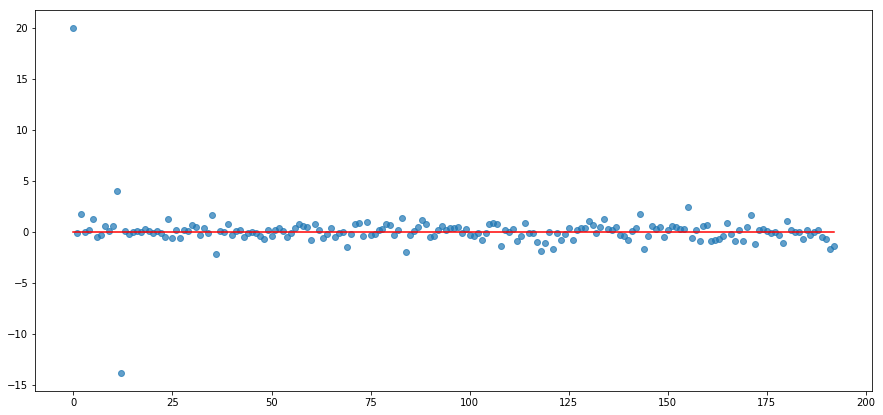

In [27]:
plt.figure(figsize = (15,7))
plt.scatter(range(len(ts_wage_trans['Wage_boxcox'])),sarimax_residuals, alpha=0.7)
plt.plot(range(len(ts_wage_trans['Wage_boxcox'])),[0]*len(ts_wage_trans['Wage_boxcox']), color = 'r')

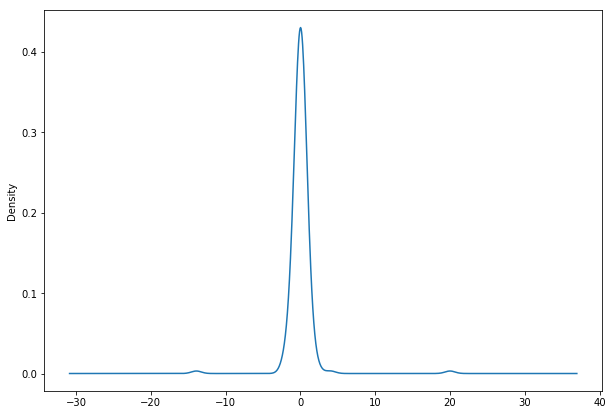

In [28]:
sarimax_residuals.plot(kind='kde', figsize=(10,7))

###### Unbiased test (Wilcoxon statistic).

In [29]:
print('p-value = {:.2f}'.format(scipy.stats.wilcoxon(sarimax_residuals)[1]))

p-value = 0.94


In [30]:
print('mean = {:.2f}'.format(sarimax_residuals.mean()))

mean = 0.04


###### Residuals are unbiassed. 

###### Stationarity check (KPSS) 

In [31]:
result_KPSS_residuals = sm.tsa.kpss(np.array(sarimax_residuals).flatten())
print('KPSS statistics = {:.2f}'.format(result_KPSS_residuals[0]))
print('KPSS p_value = {:.2f}'.format(result_KPSS_residuals[1]))

KPSS statistics = 0.20
KPSS p_value = 0.10


###### Residuals are stationary. 

###### ACF and PACF analysis

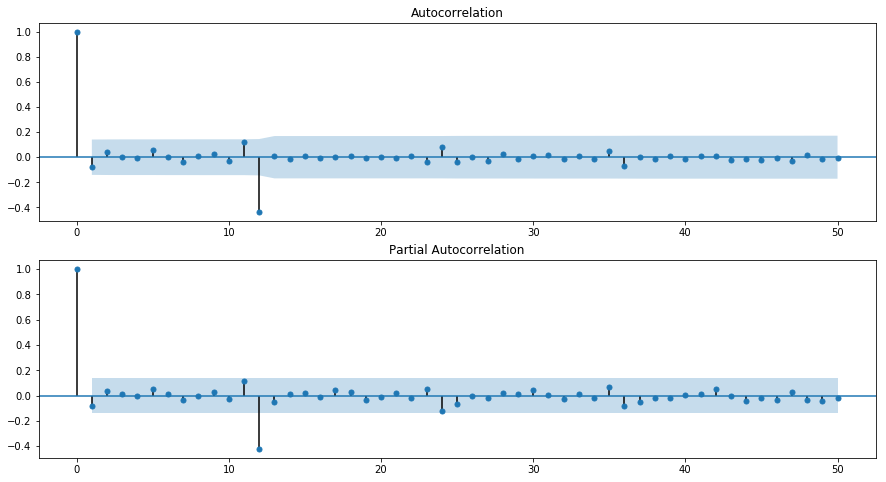

In [32]:
plt.clf()
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_residuals.values.squeeze(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_residuals.values.squeeze(), lags=50, ax=ax2)


###### Durbin - Watson test for no correlation.
The null hypothesis of the test is that there is no serial correlation. The test statistic is approximately equal to 2*(1-r) where ``r`` is the sample autocorrelation of the residuals. Thus, for r == 0, indicating no serial correlation, the test statistic equals 2. This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the moreevidence for negative serial correlation.

In [33]:
print('Durbin - Watson statistics = {:.2f}'.format(sm.stats.durbin_watson(sarimax_residuals.values)))

Durbin - Watson statistics = 1.59


###### Residuals are not correlated. 

###### Shapiro - Wilk test for normality.
The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

In [34]:
print('Shapiro - Wilk p-value = {:.2f}'.format(scipy.stats.shapiro(sarimax_residuals.values)[1]))

Shapiro - Wilk p-value = 0.00


###### Residuals are not from Normal distribution. 

#####  Final report for Residuals: Unbiased, Sattionary, Not Correlated and Not from Normal Distribution.

### 7. Forecasting

In [35]:
forecast_wage = sarimax_model_results.predict(start='2015-01-01', end='2017-01-01', dynamic=True)
forecast_wage = forecast_wage.to_frame(name='Real wage')

In [36]:
# the inverse of box-cox

def invboxcox(y,Lambda):
   if Lambda == 0:
      return(np.exp(y))
   else:
      return((Lambda*y+1)**(1/Lambda))


In [37]:
lbd = scipy.stats.boxcox(ts_wage_trans['Real wage'].values)[1]
forecast_wage = invboxcox(forecast_wage, Lambda = lbd)

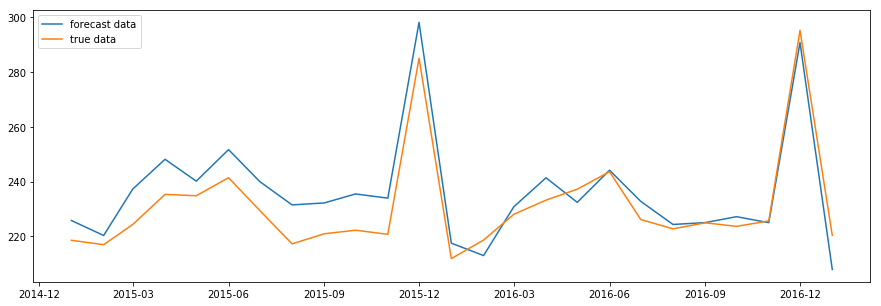

In [38]:
plt.clf()
plt.figure(figsize=(15,5))
plt.plot(forecast_wage, label='forecast data')
plt.plot(testing_ts_wage, label='true data')
plt.legend()

In [39]:
ix = range(len(testing_ts_wage.index))

macape_loss, _ = qualityMACAPE(forecast_wage.iloc[ix], testing_ts_wage.iloc[ix])
rmse_loss, _ = qualityRMSE(forecast_wage.iloc[ix], testing_ts_wage.iloc[ix])

print('Test Accuracy = {:.2f}%, RMSE loss = {:.2f}'.format(float(1-macape_loss.values)*100, float(rmse_loss.values)))

Test Accuracy = 96.83%, RMSE loss = 8.70


* The result is better than SES and comparable with the result of Winters model.

**II. Find the best parameters of ARIMA automaticaly** 
* 0) Use data before 01.02.2015 
* 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
* 2) Run grid search for ARIMA parameters (at least for 3 distinct values for $p,q,d, P, Q, D$). 
How many time does it take?
* 4) Find the best set of parameters according to AIC.
* 5) Build the forecast of the best model and it's forecasting interval for period from 01.02.2015 to 01.01.2017.
* 6) Calculate loss MACAPE of your forecast.

##### Auxilary functions:

In [40]:
## Training of SARIMAX model
def train_plotting_SARIMAX(parameters,data, plotting_frequency, independent_variables):
    
    train_ts = pd.DataFrame(data)
    
    p1 = parameters['p']
    p2 = parameters['d']
    p3 = parameters['q']
    p4 = parameters['P']
    p5 = parameters['D']
    p6 = parameters['Q']
    p7 = parameters['s']
    
    loop = itertools.product(p1, p2, p3, p4, p5, p6, p7, repeat=1)
    size = len(p1)*len(p2)*len(p3)*len(p4)*len(p5)*len(p6)*len(p7)
    
    column_names = ['p','d','q','P','D','Q','s','AIC','BIC','MACAPE','RMSE']
    indexes = range(size)
    results_data = pd.DataFrame(index = indexes, columns = column_names)  

    ix = range(len(train_ts.index))
    i = 0
    for p, d, q, P, D, Q, s in loop:
        
        results_data.loc[i, 'p'] = p
        results_data.loc[i, 'd'] = d
        results_data.loc[i, 'q'] = q
        results_data.loc[i, 'P'] = P
        results_data.loc[i, 'D'] = D
        results_data.loc[i, 'Q'] = Q
        results_data.loc[i, 's'] = s
        
        try:
            model = sm.tsa.SARIMAX(endog = train_ts, exog = independent_variables, order = (p, d, q), 
                                   seasonal_order = (P, D, Q, s), enforce_invertibility = False)
            results = model.fit()
            forecasted_ts = results.predict()
            forecasted_ts = forecasted_ts.to_frame(name=train_ts.columns[0])
            
            macape_loss, _ = qualityMACAPE(train_ts.iloc[ix], forecasted_ts.iloc[ix])
            rmse_loss, _ = qualityRMSE(train_ts.iloc[ix], forecasted_ts.iloc[ix])

            results_data.loc[i, 'AIC'] = results.aic
            results_data.loc[i, 'BIC'] = results.bic
            results_data.loc[i, 'MACAPE'] = macape_loss[0]
            results_data.loc[i, 'RMSE'] = rmse_loss[0]
            
            
            if i % plotting_frequency == 0:
                title = ''
                title = ('p=' + str(p) + ', d=' + str(d) + ', q=' + str(q) + ', P=' + str(P) + 
                         ', D=' + str(D) + ', Q=' + str(Q) + ', s=' + str(s) + 
                         ', AIC=' + str('{:0.0f}'.format(results.aic)) + ', RMSE=' + str('{:0.2f}'.format(rmse_loss[0])))
                plt.figure(figsize=(15,5))
                plt.plot(train_ts,linewidth=1.0,label='true data')
                plt.plot(forecasted_ts,linewidth=2.0, label='forecasted data')
                plt.legend()
                plt.xlabel("Time ticks")
                plt.ylabel("TS values")
                plt.title(title, fontsize=16)
            
        except (MemoryError, ValueError, np.linalg.linalg.LinAlgError):
            
            results_data.loc[i, 'AIC'] = np.nan
            results_data.loc[i, 'BIC'] = np.nan
            results_data.loc[i, 'MACAPE'] = np.nan
            results_data.loc[i, 'RMSE'] = np.nan
        
        i = i + 1
        
    min_AIC_index = results_data['AIC'].argmin()
    min_RMSE_index = results_data['RMSE'].argmin()
    optimal_result_AIC = dict(results_data.iloc[min_AIC_index])
    optimal_result_RMSE = dict(results_data.iloc[min_RMSE_index])
    
    return results_data, optimal_result_AIC, optimal_result_RMSE

## only optimal forecast
def optimal_forecast_SARIMAX(train_data, test_data, optimal_result, dynamic):
    
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    
    p = optimal_result['p']
    d = optimal_result['d']
    q = optimal_result['q']
    P = optimal_result['P']
    D = optimal_result['D']
    Q = optimal_result['Q']
    s = optimal_result['s']
    
    model = sm.tsa.SARIMAX(endog = train_data, order = (p, d, q), seasonal_order = (P, D, Q, s), enforce_invertibility = False)
    results = model.fit()
    forecast = results.predict(start = test_data.index[0], end = test_data.index[-1], dynamic = dynamic)
    forecast = forecast.to_frame(name = test_data.columns[0])
    
    return forecast

## only optimal parameters
def print_optimal_result_SARIMAX(optimal_result):
    print('Optimal paramaters for model = SARIMAX are:'
          '\n optimal_p =', '{:0.0f}'.format(optimal_result['p']),
          '\n optimal_d =', '{:0.0f}'.format(optimal_result['d']),
          '\n optimal_q =', '{:0.0f}'.format(optimal_result['q']),
          '\n optimal_P =', '{:0.0f}'.format(optimal_result['P']),
          '\n optimal_D =', '{:0.0f}'.format(optimal_result['D']),
          '\n optimal_Q =', '{:0.0f}'.format(optimal_result['Q']),
          '\n optimal_s =', '{:0.0f}'.format(optimal_result['s'])
         )
    return [
           optimal_result['p'], optimal_result['d'], optimal_result['q'],
           optimal_result['P'], optimal_result['D'], optimal_result['Q'], optimal_result['s'],
           optimal_result['AIC'], optimal_result['RMSE']
           ]   

##### Search parameters:

In [41]:
grid_search_p = {'p':[1,2], 'd':[1], 'q':[1,2], 'P':[2,3,4,5], 'D':[1,2], 'Q':[2,3,4,5], 's':[12]}

#####  Grid search:

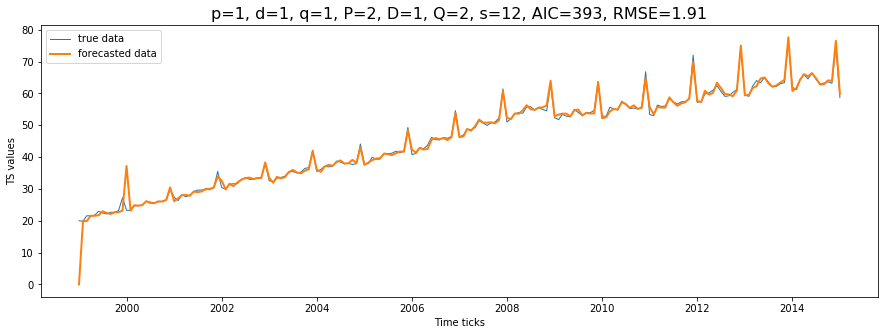

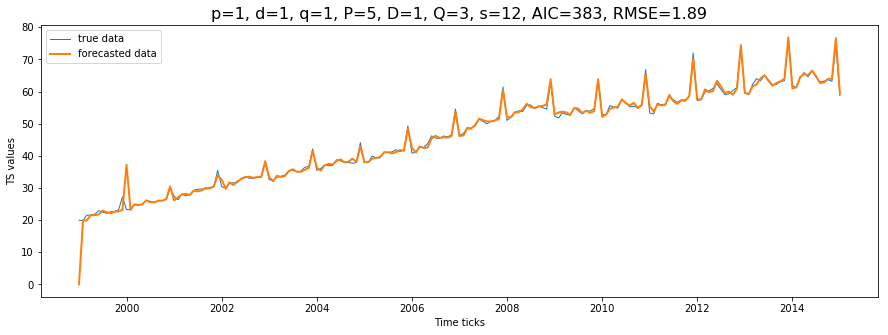

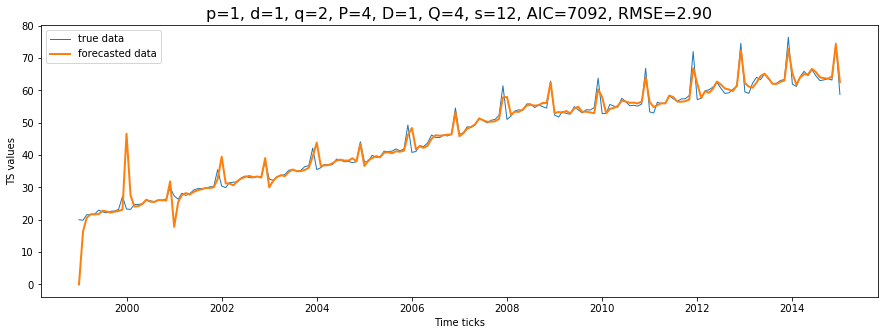

In [42]:
wage_ts_search_data, wage_min_aic_params, wage_min_rmse_params = train_plotting_SARIMAX(parameters = grid_search_p, 
                                                                                        data = ts_wage_trans['Wage_boxcox'], 
                                                                                        plotting_frequency = 25,
                                                                                        independent_variables = None
                                                                                        )

In [43]:
wage_ts_search_data.head(10)

,p,d,q,P,D,Q,s,AIC,BIC,MACAPE,RMSE
0,1,1,1,2,1,2,12,393.307,416.146,0.0249038,1.90582
1,1,1,1,2,1,3,12,394.899,421,0.0248021,1.90468
2,1,1,1,2,1,4,12,6029.56,6058.92,0.0350673,2.84417
3,1,1,1,2,1,5,12,NaN,NaN,NaN,NaN
4,1,1,1,2,2,2,12,389.609,412.448,0.0285049,2.43014
5,1,1,1,2,2,3,12,394.93,421.031,0.0288025,2.43203
6,1,1,1,2,2,4,12,7047.65,7077.01,0.0345761,3.18283
7,1,1,1,2,2,5,12,NaN,NaN,NaN,NaN
8,1,1,1,3,1,2,12,394.777,420.879,0.0248701,1.90528
9,1,1,1,3,1,3,12,399.408,428.772,0.0250597,1.90744


In [45]:
wage_ts_search_data.to_csv(path_or_buf='C:/Users/AM000110/Desktop/ML/TimeSeries/Practise & Lab/data/monthly-wage-grid-search.csv')

######  Otpimal parameters for according to min of AIC:

In [46]:
print_optimal_result_SARIMAX(wage_min_aic_params)

Optimal paramaters for model = SARIMAX are:
 optimal_p = 1 
 optimal_d = 1 
 optimal_q = 1 
 optimal_P = 3 
 optimal_D = 2 
 optimal_Q = 2 
 optimal_s = 12


[1, 1, 1, 3, 2, 2, 12, 378.01987110917662, 2.4223681984592136]

######  Otpimal parameters for according to min of RMSE:

In [47]:
print_optimal_result_SARIMAX(wage_min_rmse_params)

Optimal paramaters for model = SARIMAX are:
 optimal_p = 1 
 optimal_d = 1 
 optimal_q = 2 
 optimal_P = 5 
 optimal_D = 1 
 optimal_Q = 3 
 optimal_s = 12


[1, 1, 2, 5, 1, 3, 12, 385.32095869968947, 1.8922122623289022]

######  Forecasting with these parameters:

In [51]:
wage_ts_opt_frc_aic = optimal_forecast_SARIMAX(ts_wage_trans['Wage_boxcox'],testing_ts_wage,wage_min_aic_params)
wage_ts_opt_frc_rmse = optimal_forecast_SARIMAX(ts_wage_trans['Wage_boxcox'],testing_ts_wage,wage_min_rmse_params)

lbd = scipy.stats.boxcox(ts_wage_trans['Real wage'].values)[1]
wage_ts_opt_frc_aic = invboxcox(wage_ts_opt_frc_aic, Lambda = lbd)
wage_ts_opt_frc_rmse = invboxcox(wage_ts_opt_frc_rmse, Lambda = lbd)

######  Plotting forecasts with these parameters:

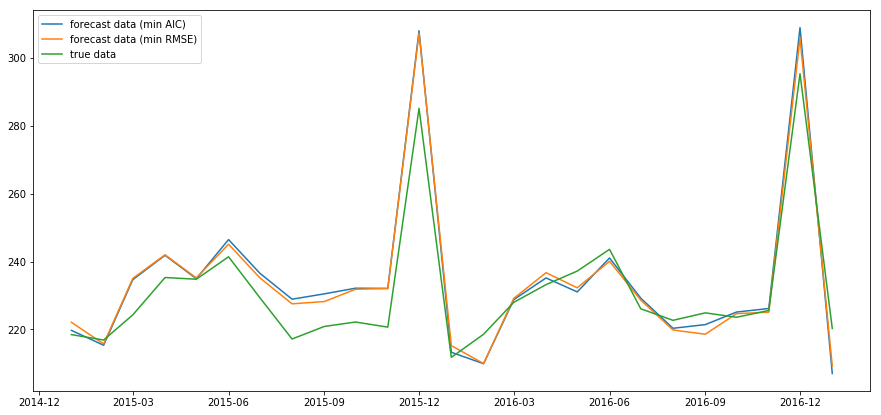

In [52]:
plt.clf()
plt.figure(figsize=(15,7))
plt.plot(wage_ts_opt_frc_aic, label='forecast data (min AIC)')
plt.plot(wage_ts_opt_frc_rmse, label='forecast data (min RMSE)')
plt.plot(testing_ts_wage, label='true data')
plt.legend()

######  Accuracy calculation:

In [53]:
ix = range(len(testing_ts_wage.index))

wage_ts_min_aic_macape = qualityMACAPE(wage_ts_opt_frc_aic.iloc[ix],testing_ts_wage.iloc[ix])[0]
wage_ts_min_rmse_macape = qualityMACAPE(wage_ts_opt_frc_rmse.iloc[ix],testing_ts_wage.iloc[ix])[0]          

print('min AIC Test accuracy = {:.2f}%, min RMSE Test accuracy= {:.2f}%'.format(float(1-wage_ts_min_aic_macape.values)*100, 
                                                                     float(1-wage_ts_min_rmse_macape.values)*100))

min AIC Test accuracy = 97.38%, min RMSE Test accuracy= 97.43%


<h1 align="center">3. ARIMA Momdel for Energy dataset (55%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_consumption.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters yourself **
Follow to the steps from 2.I. 

**II. Find the best parameters of ARIMA automaticaly**

** III. Adding of exogenous variables**

* 1) Try to add in models from 3.I. and 3.II exogenious variables (at least one of Temp1, Temp2, Saturday and Sunday).
* 2) Does it make accuracy of foreacast for period from 01.02.2015 to 01.01.2017 better?

# 3.1 Select ARIMA parameters yourself

## 1. Data reading, plotting, visual investigation

In [107]:
energy_ts = pd.read_csv('C:/Users/AM000110/Desktop/ML/TimeSeries/Practise & Lab/data/energy_consump.csv', sep=',', decimal='.', parse_dates=True, index_col='Date')
energy_ts = energy_ts.sort_index()
energy_ts.head()

,Hub,ZSP,EnergyConsump,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Date,,,,,,,,,,,,,,,,,,,,
2010-01-01,Center,FZSZOE27,147487.171,-17.8,-16.9,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,Center,FZSZOE27,155433.800,-17.8,-20.3,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,Center,FZSZOE27,164140.232,-16.4,-24.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,Center,FZSZOE27,171382.848,-10.2,-15.7,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,Center,FZSZOE27,170188.290,-7.2,-8.8,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
energy_ts.index[0]

Timestamp('2010-01-01 00:00:00')

In [109]:
energy_ts.index[-1]

Timestamp('2015-05-27 00:00:00')

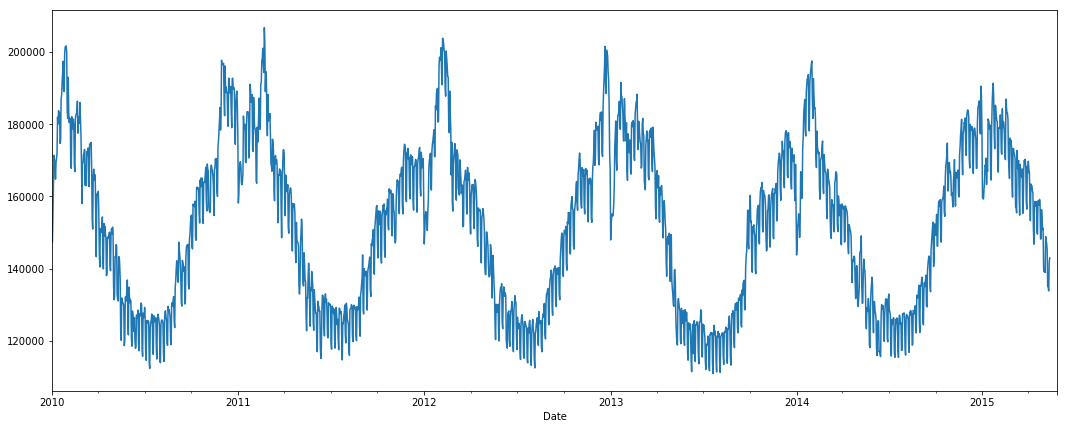

In [110]:
energy_ts['EnergyConsump'].plot(figsize=(18,7))

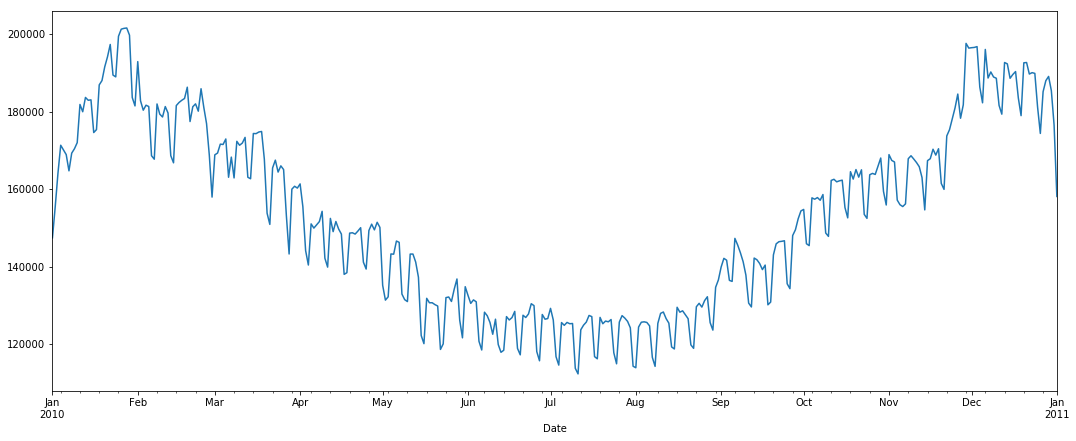

In [111]:
energy_ts['EnergyConsump']['2010.01.01' : '2011.01.01'].plot(figsize=(18,7))

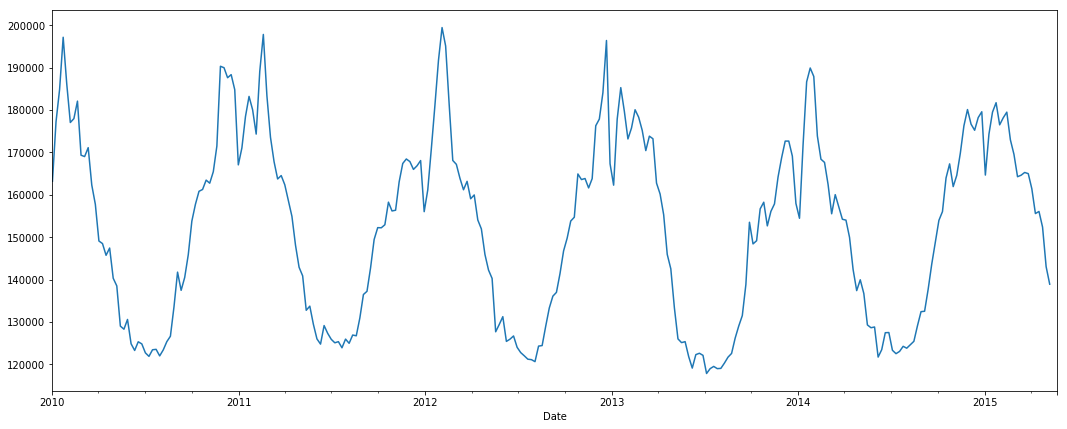

In [112]:
energy_ts['EnergyConsump'].resample('7D').mean().plot(figsize=(18,7))

* There is weekly seasonality

## 2. Stationarity check

###### Plotting histogram of data:

In [113]:
energy_consump_ts = pd.DataFrame(energy_ts['EnergyConsump']).dropna()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027ADB4DEF98>]], dtype=object)

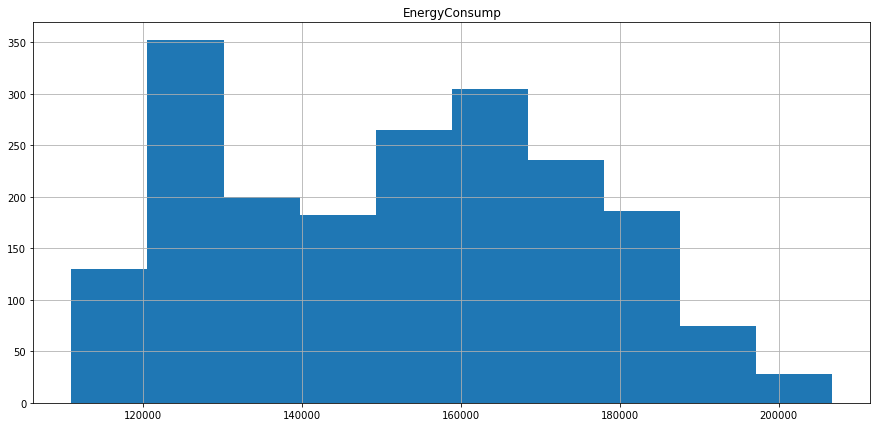

In [114]:
energy_consump_ts.hist(figsize=(15,7))

* From graph we can see that data is not from exact distribution, it varies a lot.

###### Data spliting into some parts and variance comparision

In [115]:
split_size = 3
split = int(energy_consump_ts.index.size/split_size - 1)

for i in range(split_size):
    print('variance_{} = {:.2f}'.format(i+1, energy_consump_ts.iloc[split*i:split*(i+1)].var()[0]))

variance_1 = 545069813.78
variance_2 = 523911879.78
variance_3 = 426570045.42


* Variance varies

###### Statistic tests (KPSS, ADF)

In [116]:
print('KPSS statistics = {:.2f}'.format(sm.tsa.kpss(energy_consump_ts.values.flatten())[0]))
print('KPSS p_value = {:.2f}'.format(sm.tsa.kpss(energy_consump_ts.values.flatten())[1]))

KPSS statistics = 0.10
KPSS p_value = 0.10


In [117]:
print('ADF statistics = {:.2f}'.format(sm.tsa.adfuller(energy_consump_ts.values.flatten())[0]))
print('ADF p_value = {:.2f}'.format(sm.tsa.adfuller(energy_consump_ts.values.flatten())[1]))

ADF statistics = -3.17
ADF p_value = 0.02


* According to these tests, data is stationary with high probability, but anyway we will do seasonal differencing.

## 3. Data transforming and seasonal differencing

######  Weekly differencing:

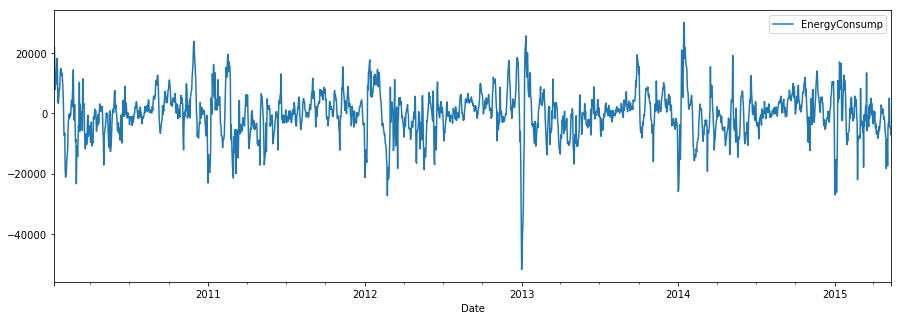

In [118]:
p = 7

energy_consump_ts_sd7 = (energy_consump_ts - energy_consump_ts.shift(p))[p:]
energy_consump_ts_sd7.plot(figsize=(15,5))

In [119]:
print('KPSS statistics = {:.2f}'.format(sm.tsa.kpss(energy_consump_ts_sd7.values.flatten())[0]))
print('KPSS p_value = {:.2f}'.format(sm.tsa.kpss(energy_consump_ts_sd7.values.flatten())[1]))

KPSS statistics = 0.04
KPSS p_value = 0.10


In [120]:
print('ADF statistics = {:.2f}'.format(sm.tsa.adfuller(energy_consump_ts_sd7.values.flatten())[0]))
print('ADF p_value = {:e}'.format(sm.tsa.adfuller(energy_consump_ts_sd7.values.flatten())[1]))

ADF statistics = -7.54
ADF p_value = 3.430530e-11


###### Yearly differencing:

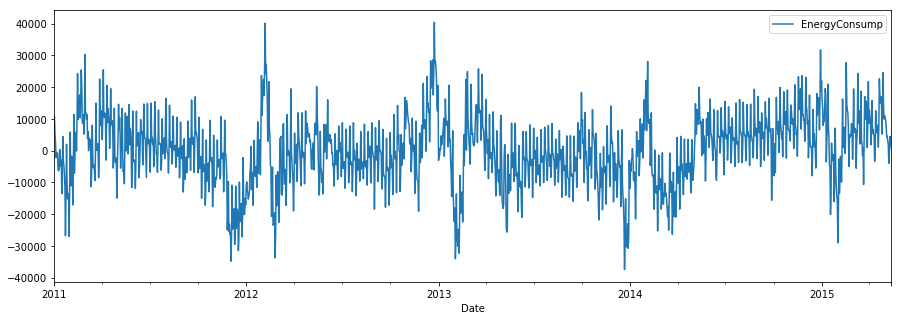

In [121]:
p = 365

energy_consump_ts_sd365 = (energy_consump_ts - energy_consump_ts.shift(p))[p:]
energy_consump_ts_sd365.plot(figsize=(15,5))

In [122]:
print('KPSS statistics = {:.2f}'.format(sm.tsa.kpss(energy_consump_ts_sd365.values.flatten())[0]))
print('KPSS p_value = {:.2f}'.format(sm.tsa.kpss(energy_consump_ts_sd365.values.flatten())[1]))

KPSS statistics = 0.46
KPSS p_value = 0.05


In [123]:
print('ADF statistics = {:.2f}'.format(sm.tsa.adfuller(energy_consump_ts_sd365.values.flatten())[0]))
print('ADF p_value = {:e}'.format(sm.tsa.adfuller(energy_consump_ts_sd365.values.flatten())[1]))

ADF statistics = -6.26
ADF p_value = 4.232284e-08


###### 1 time first differencing of weekly differenced data:

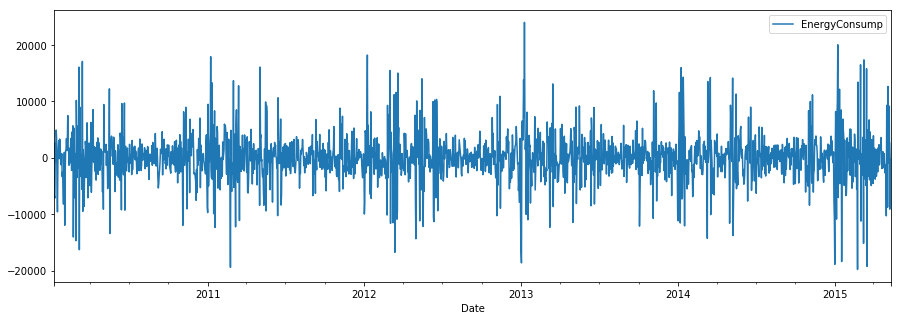

In [125]:
p = 1

energy_consump_ts_sd7_fd1 = (energy_consump_ts_sd7 - energy_consump_ts_sd7.shift(p))[p:]
energy_consump_ts_sd7_fd1.plot(figsize=(15,5))

In [126]:
print('KPSS statistics = {:.2f}'.format(sm.tsa.kpss(energy_consump_ts_sd7_fd1.values.flatten())[0]))
print('KPSS p_value = {:.2f}'.format(sm.tsa.kpss(energy_consump_ts_sd7_fd1.values.flatten())[1]))

KPSS statistics = 0.03
KPSS p_value = 0.10


In [127]:
print('ADF statistics = {:.2f}'.format(sm.tsa.adfuller(energy_consump_ts_sd7_fd1.values.flatten())[0]))
print('ADF p_value = {:e}'.format(sm.tsa.adfuller(energy_consump_ts_sd7_fd1.values.flatten())[1]))

ADF statistics = -13.26
ADF p_value = 8.402383e-25


* Seems that this is much more stationary than the original data.

## 4. ACF and PACF 

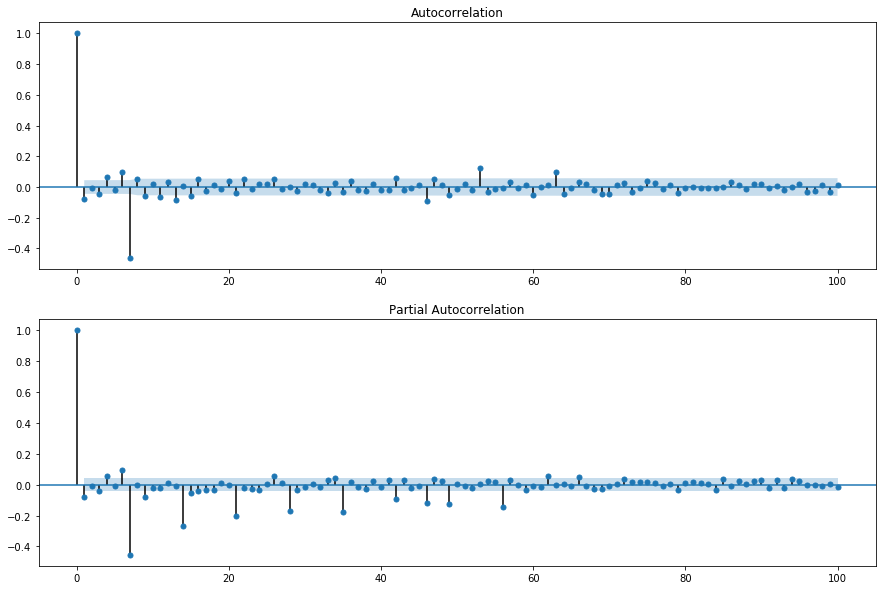

In [129]:
plt.clf()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.tsa.graphics.plot_acf(energy_consump_ts_sd7_fd1.values.squeeze(),lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.tsa.graphics.plot_pacf(energy_consump_ts_sd7_fd1.values.squeeze(),lags=100, ax=ax2)

* From this graphs we can not choose the p and the q.

## 5. Model training 

In [130]:
energy_consump_ts_train = energy_consump_ts[:'2015.01.01']
energy_consump_ts_test = energy_consump_ts['2015.01.01':]

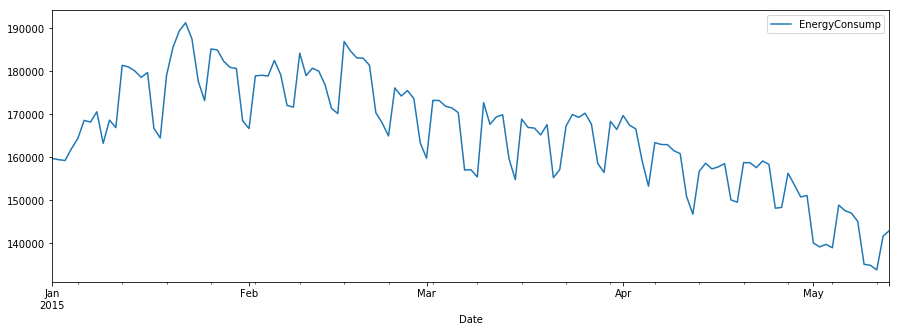

In [131]:
energy_consump_ts_test.plot(figsize = (15,5))

In [77]:
energy_model = sm.tsa.SARIMAX(endog = energy_consump_ts_train, order = (1,1,1), seasonal_order = (7,1,7,7), 
                              enforce_invertibility = False,)

energy_model_results = energy_model.fit()

In [78]:
print(energy_model_results.summary())

                                 Statespace Model Results                                
Dep. Variable:                     EnergyConsump   No. Observations:                 1827
Model:             SARIMAX(1, 1, 1)x(7, 1, 7, 7)   Log Likelihood              -17399.092
Date:                           Wed, 14 Jun 2017   AIC                          34832.183
Time:                                   15:55:06   BIC                          34925.861
Sample:                               01-01-2010   HQIC                         34866.737
                                    - 01-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8586      1.304      0.658      0.510      -1.698       3.415
ma.L1         -0.8558      1.309     -0.654

## 6. Residual analysis

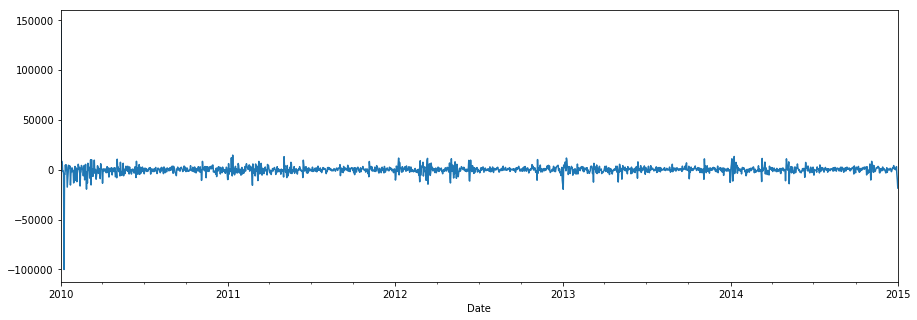

In [79]:
energy_residuals = energy_model_results.resid
energy_residuals.plot(figsize=(15,5))

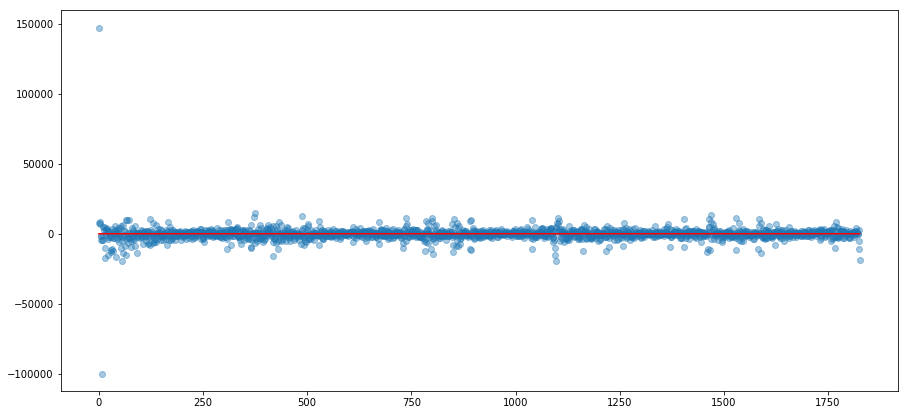

In [80]:
plt.figure(figsize=(15,7))
plt.scatter(range(energy_residuals.index.size),energy_residuals.values, alpha = 0.4)
plt.plot(range(energy_residuals.index.size),[0]*(energy_residuals.index.size), c = 'r' )

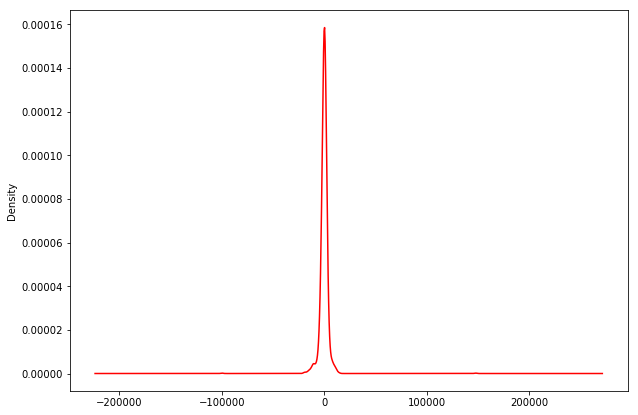

In [81]:
energy_residuals.plot(kind = 'kde', c = 'r', figsize=(10,7))

##### 6.1 Unbiased test (Wilcoxon statistics (null hypothesis = unbiasedness))

In [82]:
print('p-value = {:.2f}'.format(scipy.stats.wilcoxon(energy_residuals)[1]))
print('mean = {:.2f}'.format(energy_residuals.mean()))

p-value = 0.24
mean = -175.82


##### 6.2 Stationarity test (KPSS  statistics (null hypothesis = stionarity)) 

In [83]:
print('KPSS statistics = {:.2f}'.format(sm.tsa.kpss(energy_residuals.values.flatten())[0]))
print('KPSS p_value = {:.2f}'.format(sm.tsa.kpss(energy_residuals.values.flatten())[1]))

KPSS statistics = 0.41
KPSS p_value = 0.07


##### 6.3 Correlation test (Durbin - Watson statistics (null hypothesis = no serial correlation, should be = 2)) 

In [84]:
print('Durbin - Watson statistics = {:.2f}'.format(sm.stats.durbin_watson(energy_residuals.values)))

Durbin - Watson statistics = 1.49


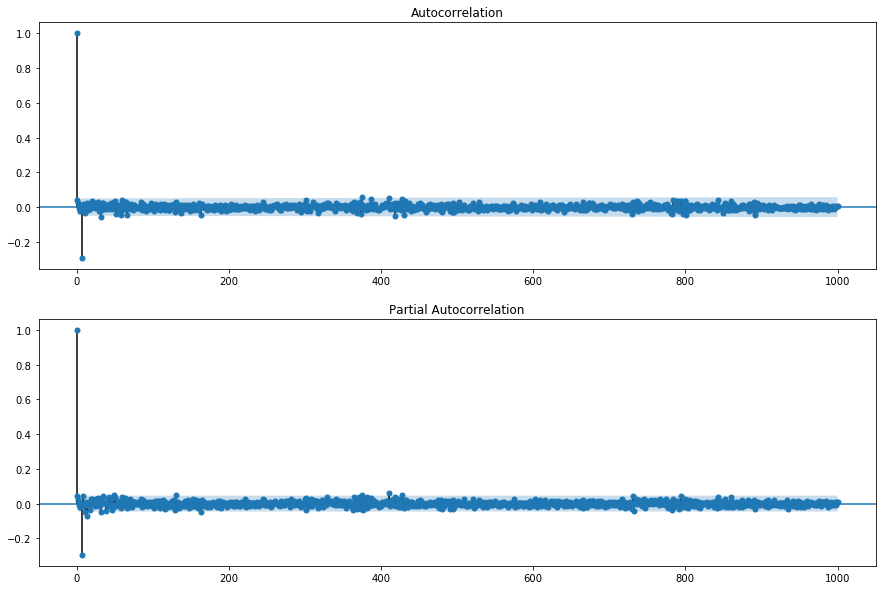

In [85]:
plt.clf()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.tsa.graphics.plot_acf(energy_residuals.values.squeeze(),lags=1000, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.tsa.graphics.plot_pacf(energy_residuals.values.squeeze(),lags=1000, ax=ax2)

##### 6.4 Normality test (Shapiro - Wilk statistics (null hypothesis = data is from Normal distribution)) 

In [86]:
print('Shapiro - Wilk p-value = {:.2f}'.format(scipy.stats.shapiro(energy_residuals.values)[1]))

Shapiro - Wilk p-value = 0.00


#### Final result for Residuals
* they are unbiased
* they are stationary
* they are uncorrelated
* they are not from Normal distribution

## 7. Forecasting and testing

In [90]:
energy_forecast_train = energy_model_results.predict(start = energy_consump_ts_train.index[0], end = energy_consump_ts_train.index[-1])

energy_forecast_test = energy_model_results.predict(start = energy_consump_ts_test.index[0], end = energy_consump_ts_test.index[-1], 
                                            dynamic =True)  

energy_forecast_train = energy_forecast_train.to_frame(name=energy_consump_ts_train.columns[0])
energy_forecast_test = energy_forecast_test.to_frame(name=energy_consump_ts_test.columns[0])

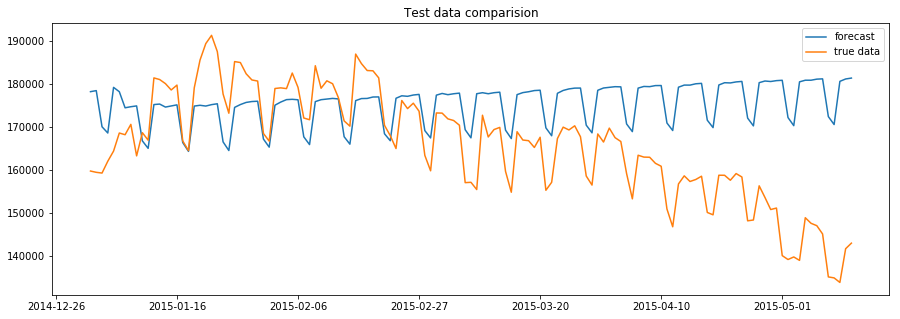

In [94]:
plt.figure(figsize=(15,5))
plt.plot(energy_forecast_test, label = 'forecast')
plt.plot(energy_consump_ts_test, label = 'true data')
plt.title('Test data comparision')
plt.legend()

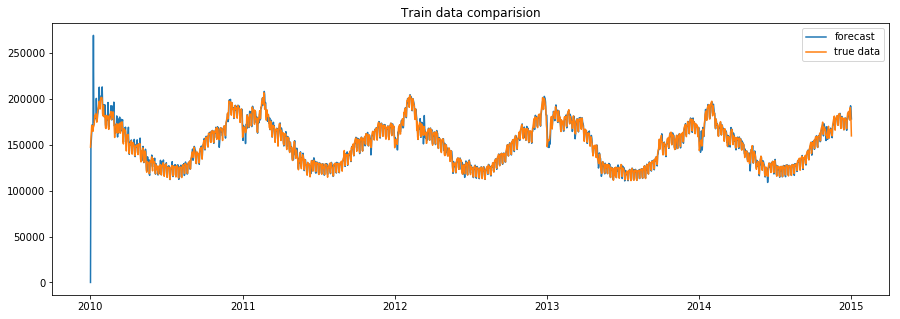

In [95]:
plt.figure(figsize=(15,5))
plt.plot(energy_forecast_train, label = 'forecast')
plt.plot(energy_consump_ts_train, label = 'true data')
plt.title('Train data comparision')
plt.legend()

In [96]:
ix = range(len(energy_consump_ts_test.index))

macape_loss, _ = qualityMACAPE(energy_forecast_test.iloc[ix], energy_consump_ts_test.iloc[ix])
rmse_loss, _ = qualityRMSE(energy_forecast_test.iloc[ix], energy_consump_ts_test.iloc[ix])

print('Test Accuracy = {:.2f}%, RMSE loss = {:.2f}'.format(float(1-macape_loss.values)*100, float(rmse_loss.values)))

Test Accuracy = 92.03%, RMSE loss = 16869.07


In [98]:
ix = range(len(energy_consump_ts_train.index))

macape_loss, _ = qualityMACAPE(energy_forecast_train.iloc[ix], energy_consump_ts_train.iloc[ix])
rmse_loss, _ = qualityRMSE(energy_forecast_train.iloc[ix], energy_consump_ts_train.iloc[ix])

print('Train Accuracy = {:.2f}%, RMSE loss = {:.2f}'.format(float(1-macape_loss.values)*100, float(rmse_loss.values)))

Train Accuracy = 98.41%, RMSE loss = 5361.28


# 3.2 Select ARIMA parameters via grid-search

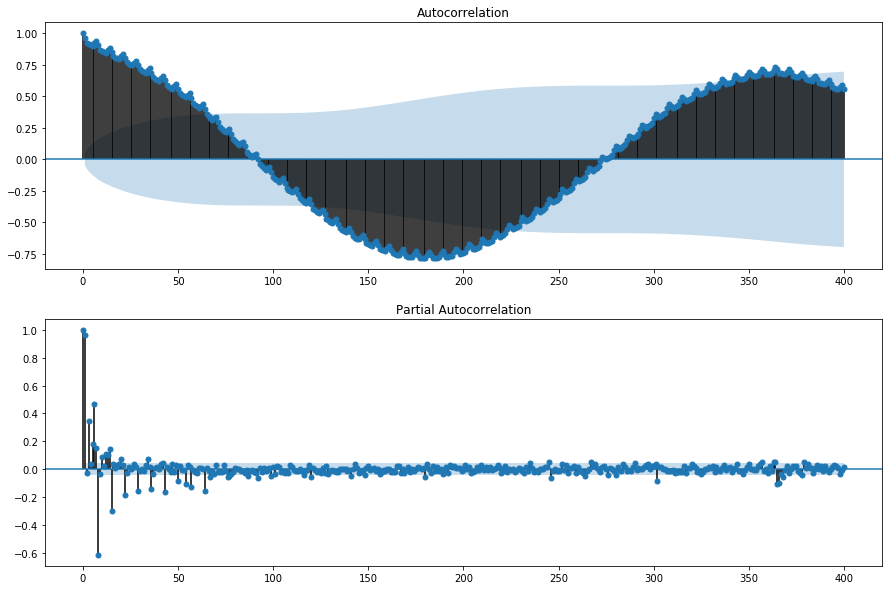

In [388]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.tsa.graphics.plot_acf(energy_consump_ts, ax=ax1, lags=400)
ax2 = fig.add_subplot(212)
fig = sm.tsa.graphics.plot_pacf(energy_consump_ts, ax=ax2, lags=400)

* Frome the graphs we see ACF is sinusoidal, PACF has spike in lag 7. So will use order (7,1,1)

##### Search parameters:

In [389]:
grid_search_energy_p = {'p':[7], 'd':[1], 'q':[1], 'P':[0,1,2], 'D':[0,1,2], 'Q':[0,1,2], 's':[7]}

#####  Grid search:

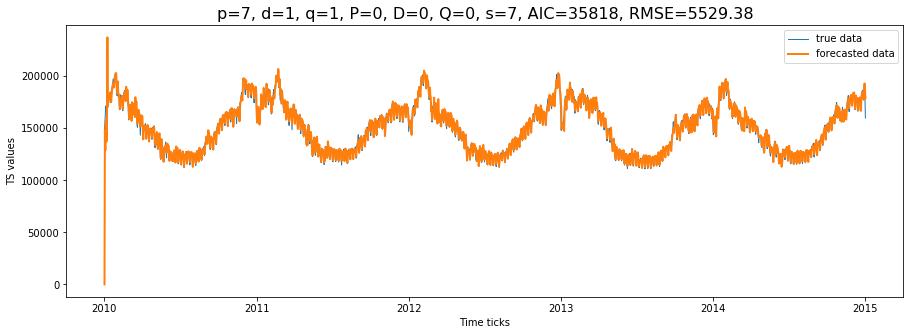

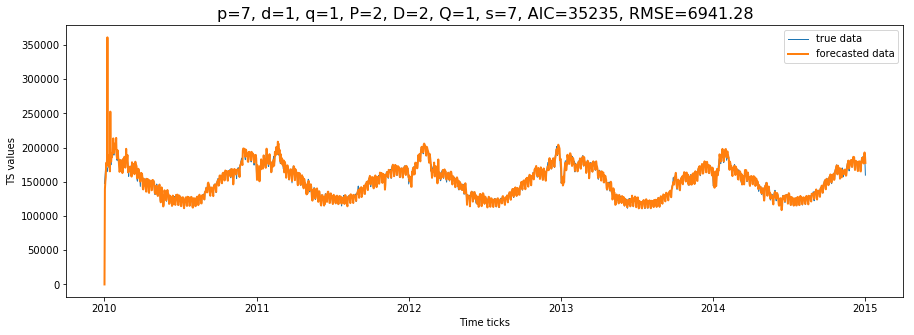

In [390]:
energy_ts_search_data, energy_min_aic_params, energy_min_rmse_params = train_plotting_SARIMAX(parameters = grid_search_energy_p, 
                                                                                        data = energy_consump_ts_train, 
                                                                                        plotting_frequency = 25,
                                                                                        independent_variables = None
                                                                                        )

In [391]:
energy_ts_search_data.to_csv(path_or_buf='C:/Users/AM000110/Desktop/ML/TimeSeries/Practise & Lab/data/energy-grid-search.csv')

######  Otpimal parameters for according to min of AIC:

In [392]:
print_optimal_result_SARIMAX(energy_min_aic_params)

Optimal paramaters for model = SARIMAX are:
 optimal_p = 7 
 optimal_d = 1 
 optimal_q = 1 
 optimal_P = 2 
 optimal_D = 1 
 optimal_Q = 1 
 optimal_s = 7


[7, 1, 1, 2, 1, 1, 7, 34722.310675137953, 5361.1067461176644]

######  Otpimal parameters for according to min of RMSE:

In [393]:
print_optimal_result_SARIMAX(energy_min_rmse_params)

Optimal paramaters for model = SARIMAX are:
 optimal_p = 7 
 optimal_d = 1 
 optimal_q = 1 
 optimal_P = 2 
 optimal_D = 0 
 optimal_Q = 2 
 optimal_s = 7


[7, 1, 1, 2, 0, 2, 7, 34897.339780042923, 4825.8714104085111]

######  Forecasting with these parameters:

In [404]:
energy_ts_opt_frc_aic_train = optimal_forecast_SARIMAX(energy_consump_ts_train, energy_consump_ts_train, energy_min_aic_params, False)
energy_ts_opt_frc_rmse_train = optimal_forecast_SARIMAX(energy_consump_ts_train, energy_consump_ts_train, energy_min_rmse_params, False)

energy_ts_opt_frc_aic_test = optimal_forecast_SARIMAX(energy_consump_ts_train, energy_consump_ts_test, energy_min_aic_params, True)
energy_ts_opt_frc_rmse_test = optimal_forecast_SARIMAX(energy_consump_ts_train, energy_consump_ts_test, energy_min_rmse_params, True)

######  Plotting forecasts with these parameters:

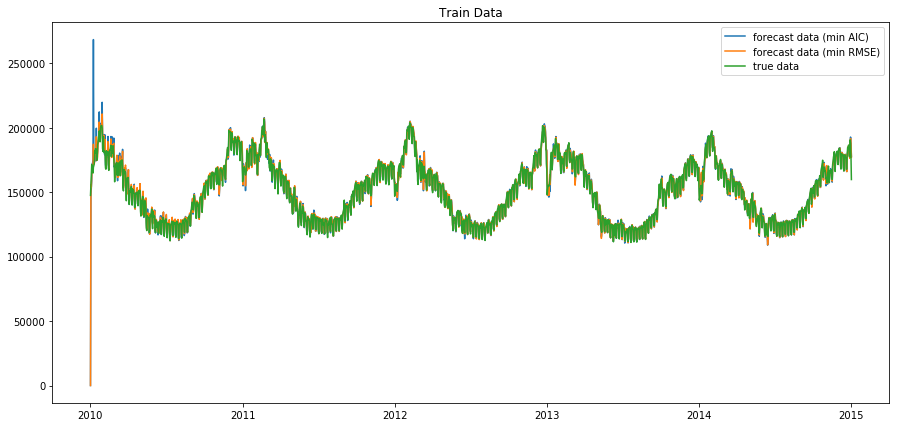

In [405]:
plt.clf()
plt.figure(figsize=(15,7))
plt.plot(energy_ts_opt_frc_aic_train, label='forecast data (min AIC)')
plt.plot(energy_ts_opt_frc_rmse_train, label='forecast data (min RMSE)')
plt.plot(energy_consump_ts_train, label='true data')
plt.title('Train Data')
plt.legend()

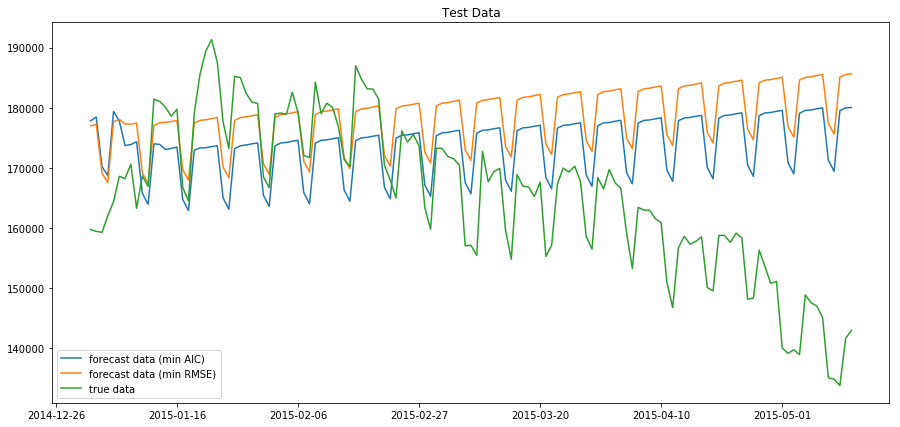

In [406]:
plt.clf()
plt.figure(figsize=(15,7))
plt.plot(energy_ts_opt_frc_aic_test, label='forecast data (min AIC)')
plt.plot(energy_ts_opt_frc_rmse_test, label='forecast data (min RMSE)')
plt.plot(energy_consump_ts_test, label='true data')
plt.title('Test Data')
plt.legend()

In [429]:
ix = range(len(energy_consump_ts_train.index))

energy_train_min_aic_macape = qualityMACAPE(energy_ts_opt_frc_aic_train.iloc[ix], energy_consump_ts_train.iloc[ix])[0]
energy_train_min_rmse_macape = qualityMACAPE(energy_ts_opt_frc_rmse_train.iloc[ix], energy_consump_ts_train.iloc[ix])[0]          

print('min AIC Train accuracy = {:.2f}%, min RMSE Train accuracy= {:.2f}%'.format(float(1-energy_train_min_aic_macape.values)*100, 
                                                                     float(1-energy_train_min_rmse_macape.values)*100))

min AIC Train accuracy = 98.42%, min RMSE Train accuracy= 98.42%


In [410]:
ix = range(len(energy_consump_ts_test.index))

energy_test_min_aic_macape = qualityMACAPE(energy_ts_opt_frc_aic_test.iloc[ix], energy_consump_ts_test.iloc[ix])[0]
energy_test_min_rmse_macape = qualityMACAPE(energy_ts_opt_frc_rmse_test.iloc[ix], energy_consump_ts_test.iloc[ix])[0]          

print('min AIC Test accuracy = {:.2f}%, min RMSE Test accuracy= {:.2f}%'.format(float(1-energy_test_min_aic_macape.values)*100, 
                                                                     float(1-energy_test_min_rmse_macape.values)*100))

min AIC Test accuracy = 92.24%, min RMSE Test accuracy= 91.14%


# 3.3 Adding of exogenous variables

In [411]:
energy_ts_exogenous = energy_ts[['EnergyConsump','Temp1','Temp2','Saturday','Sunday']]
energy_ts_exogenous = energy_ts_exogenous.dropna(how = 'any')
energy_ts_exogenous.head()

,EnergyConsump,Temp1,Temp2,Saturday,Sunday
Date,,,,,
2010-01-01,147487.171,-17.8,-16.9,0.0,1.0
2010-01-02,155433.800,-17.8,-20.3,1.0,0.0
2010-01-03,164140.232,-16.4,-24.0,0.0,1.0
2010-01-04,171382.848,-10.2,-15.7,0.0,1.0
2010-01-05,170188.290,-7.2,-8.8,0.0,1.0


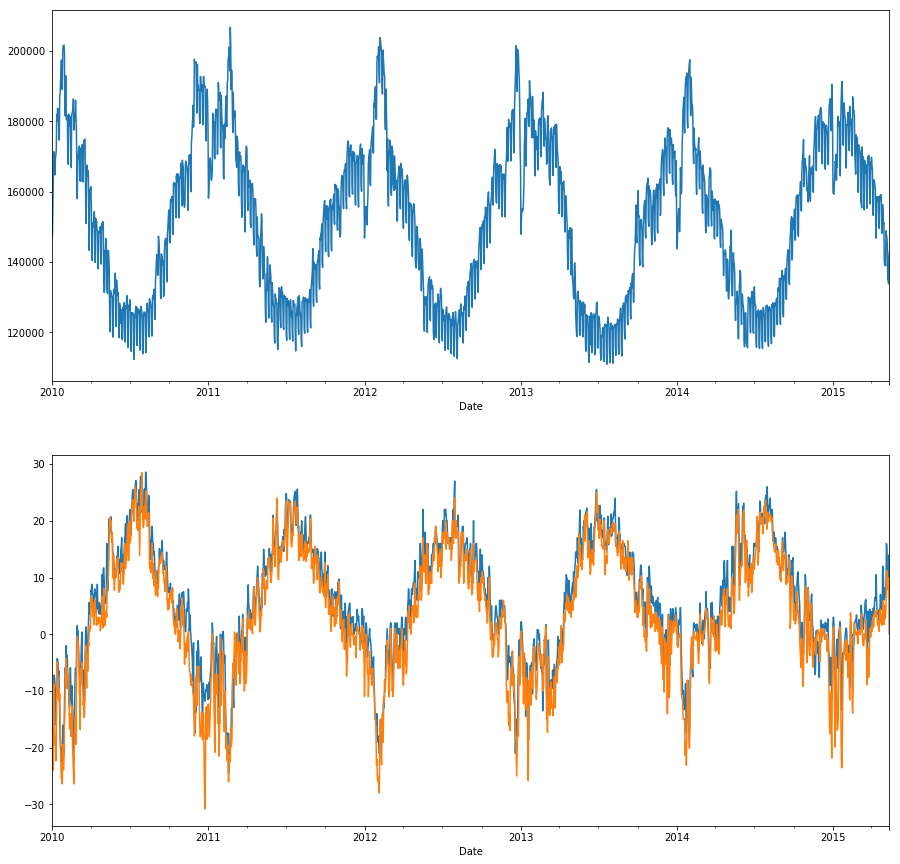

In [412]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
energy_ts_exogenous['EnergyConsump'].plot(ax=ax1)
ax2 = fig.add_subplot(212)
energy_ts_exogenous['Temp1'].plot(ax=ax2)
energy_ts_exogenous['Temp2'].plot(ax=ax2)

* We can see that there is strong connection between Tempreture and Energy Consumption

In [413]:
print('Correlation coefficient = {:.2f}, p-value = {:.2f}'.format(
    scipy.stats.pearsonr(energy_ts_exogenous['Temp1'],energy_ts_exogenous['Temp2'])[0],
    scipy.stats.pearsonr(energy_ts_exogenous['Temp1'],energy_ts_exogenous['Temp2'])[1]
                                                                ))

Correlation coefficient = 0.97, p-value = 0.00


* We see that Temp1 and Temp2 are correlated, so will use only one of them.

In [414]:
energy_ts_exogenous_train = pd.DataFrame(energy_ts_exogenous['EnergyConsump'][:'2015.01.01'])
energy_ts_exogenous_test = pd.DataFrame(energy_ts_exogenous['EnergyConsump']['2015.01.01':])

energy_ts_exogenous_var_train = pd.DataFrame(energy_ts_exogenous[['Temp1', 'Sunday', 'Saturday']][:'2015.01.01'])
energy_ts_exogenous_var_test = pd.DataFrame(energy_ts_exogenous[['Temp1', 'Sunday', 'Saturday']]['2015.01.01':])

* We will use min_aic parameters from 3.2 and add exofgs

In [415]:
energy_exogenous_model = sm.tsa.SARIMAX(endog = energy_ts_exogenous_train, exog = energy_ts_exogenous_var_train, order = (7,1,1), seasonal_order = (2,1,1,7), 
                              enforce_invertibility = False,)

energy_exogenous_model_results = energy_exogenous_model.fit()

In [423]:
energy_forecast_exogenous_train = energy_exogenous_model_results.predict(start = energy_ts_exogenous_train.index[0], end = energy_ts_exogenous_train.index[-1],
                                                                        exog=energy_ts_exogenous_var_train)

energy_forecast_exogenous_test = energy_exogenous_model_results.predict(start = energy_ts_exogenous_test.index[0], end = energy_ts_exogenous_test.index[-1], 
                                                                        dynamic = True, exog=energy_ts_exogenous_var_test.iloc[1:])  

energy_forecast_exogenous_train = energy_forecast_exogenous_train.to_frame(name=energy_ts_exogenous_train.columns[0])
energy_forecast_exogenous_test = energy_forecast_exogenous_test.to_frame(name=energy_ts_exogenous_test.columns[0])

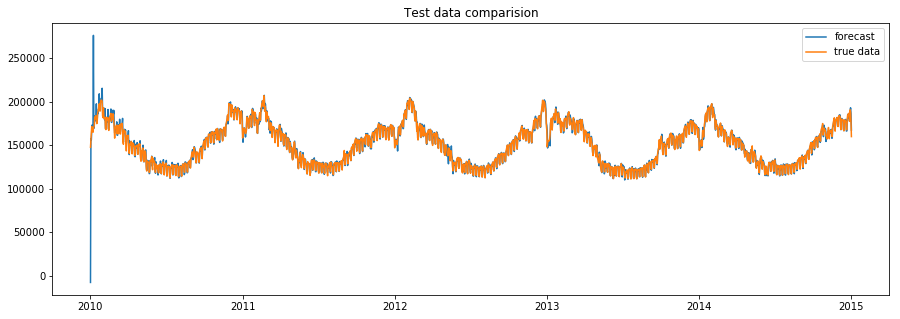

In [424]:
plt.figure(figsize=(15,5))
plt.plot(energy_forecast_exogenous_train, label = 'forecast')
plt.plot(energy_ts_exogenous_train, label = 'true data')
plt.title('Test data comparision')
plt.legend()

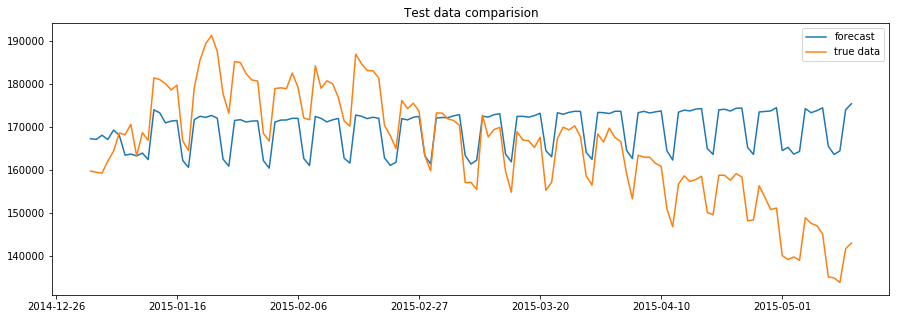

In [425]:
plt.figure(figsize=(15,5))
plt.plot(energy_forecast_exogenous_test, label = 'forecast')
plt.plot(energy_ts_exogenous_test, label = 'true data')
plt.title('Test data comparision')
plt.legend()

In [426]:
ix = range(len(energy_ts_exogenous_train.index))

macape_loss, _ = qualityMACAPE(energy_forecast_exogenous_train.iloc[ix], energy_ts_exogenous_train.iloc[ix])
rmse_loss, _ = qualityRMSE(energy_forecast_exogenous_train.iloc[ix], energy_ts_exogenous_train.iloc[ix])

print('Train Accuracy = {:.2f}%, RMSE loss = {:.2f}'.format(float(1-macape_loss.values)*100, float(rmse_loss.values)))

Train Accuracy = 98.68%, RMSE loss = 5075.04


In [428]:
ix = range(len(energy_ts_exogenous_test.index))

macape_loss, _ = qualityMACAPE(energy_forecast_exogenous_test.iloc[ix], energy_ts_exogenous_test.iloc[ix])
rmse_loss, _ = qualityRMSE(energy_forecast_exogenous_test.iloc[ix], energy_ts_exogenous_test.iloc[ix])

print('Test Accuracy = {:.2f}%, RMSE loss = {:.2f}'.format(float(1-macape_loss.values)*100, float(rmse_loss.values)))

Test Accuracy = 93.62%, RMSE loss = 12938.72


###  We have better Accuracy !!!

<h1 align="center">2. Forecasting of real TS (50%)</h1>
Build the forecast for a dataset  according to the scheme in task 2 (in Practice day 2). You can find the link to dataset that you need to forecast at the sheet 'Lab2' <a href="https://drive.google.com/open?id=11-lzxxR0aeBmEDGEW1GiIaP4X3fyCTHxTg4b0wALpzs">here</a>. 
     


## 1. Data reading

In [70]:
plastic_ts = pd.read_csv('C:/Users/AM000110/Desktop/ML/TimeSeries/Practise & Lab/data/monthly-production-of-plastics-a.csv', sep=',', decimal='.', parse_dates=True, index_col='Month')

In [73]:
plastic_ts = plastic_ts.sort_index()
plastic_ts.head()

,PlasticTonnes
Month,
1964-07-01,5518
1964-08-01,6627
1964-09-01,6544
1964-10-01,6190
1964-11-01,6948


In [74]:
plastic_ts.tail()

,PlasticTonnes
Month,
1989-02-01,49214
1989-03-01,45393
1989-04-01,55901
1989-05-01,55290
1989-06-01,58713


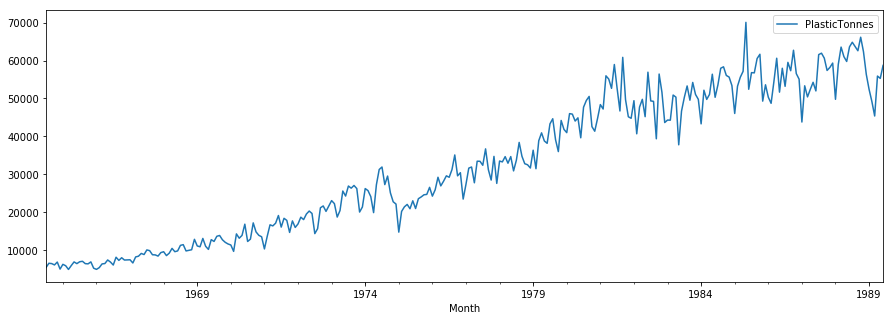

In [75]:
plastic_ts.plot(figsize=(15,5))

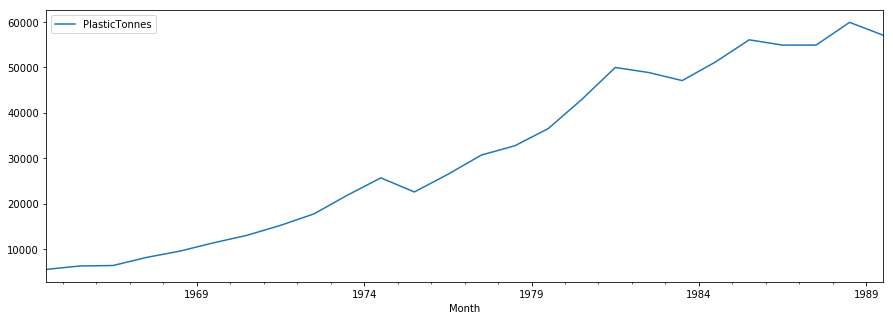

In [76]:
plastic_ts.resample('12M').mean().plot(figsize=(15,5))

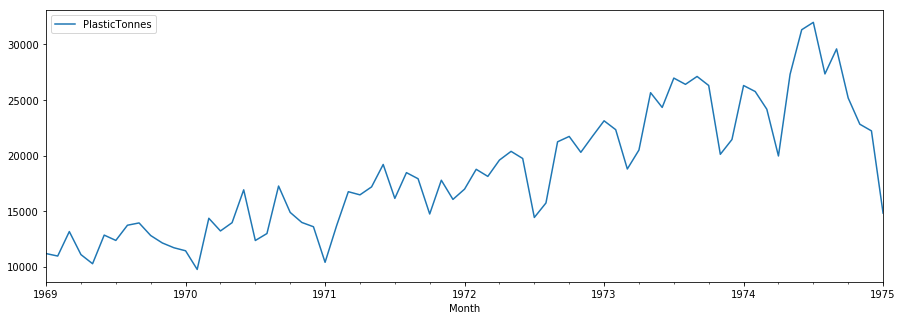

In [78]:
plastic_ts['1969.01.01':'1975.01.01'].plot(figsize=(15,5))

* Seems there is a yearly seasonality

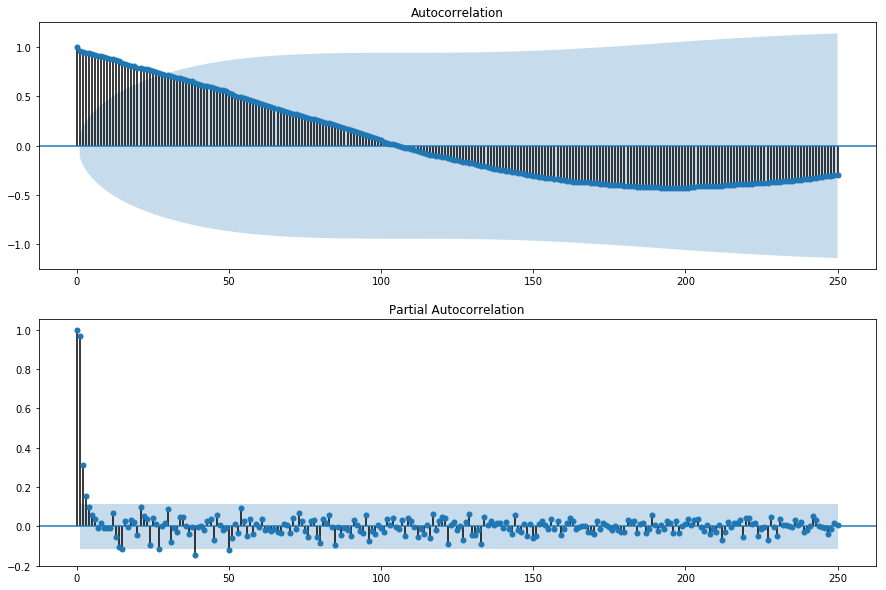

In [97]:
plt.clf()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.tsa.graphics.plot_acf(plastic_ts.values.squeeze(),lags=250, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.tsa.graphics.plot_pacf(plastic_ts.values.squeeze(),lags=250, ax=ax2)

## 2. Stationarity check

###### Plotting histogram of data:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002453D2D3D30>]], dtype=object)

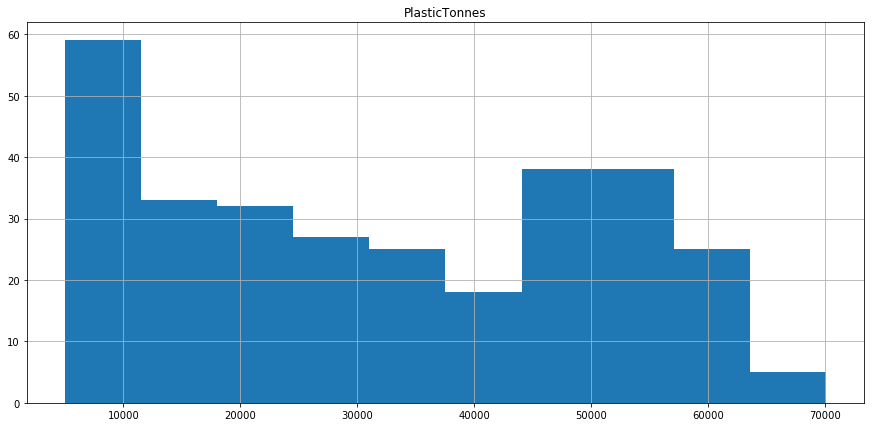

In [79]:
plastic_ts.hist(figsize=(15,7))

* From graph we can see that data is not from exact distribution, it varies a lot.

###### Data spliting into some parts and variance comparision

In [81]:
split_size = 3
split = int(plastic_ts.index.size/split_size - 1)

for i in range(split_size):
    print('variance_{} = {:.2f}'.format(i+1, plastic_ts.iloc[split*i:split*(i+1)].var()[0]))

variance_1 = 18313618.61
variance_2 = 64610274.87
variance_3 = 39238639.44


* Variance varies

###### Statistic tests (KPSS, ADF)

In [82]:
print('KPSS statistics = {:.2f}'.format(sm.tsa.kpss(plastic_ts.values.flatten())[0]))
print('KPSS p_value = {:.2f}'.format(sm.tsa.kpss(plastic_ts.values.flatten())[1]))

KPSS statistics = 1.84
KPSS p_value = 0.01


In [83]:
print('ADF statistics = {:.2f}'.format(sm.tsa.adfuller(plastic_ts.values.flatten())[0]))
print('ADF p_value = {:.2f}'.format(sm.tsa.adfuller(plastic_ts.values.flatten())[1]))

ADF statistics = -0.69
ADF p_value = 0.85


* According to these tests, data is not stationary at all.

## 3. Data transforming and seasonal differencing

######  Yearly differencing:

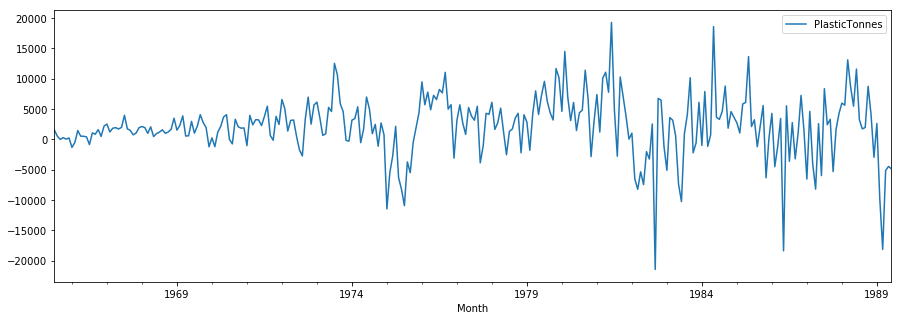

In [85]:
p = 12

plastic_ts_ts_sd365 = (plastic_ts - plastic_ts.shift(p))[p:]
plastic_ts_ts_sd365.plot(figsize=(15,5))

In [86]:
print('KPSS statistics = {:.2f}'.format(sm.tsa.kpss(plastic_ts_ts_sd365.values.flatten())[0]))
print('KPSS p_value = {:.2f}'.format(sm.tsa.kpss(plastic_ts_ts_sd365.values.flatten())[1]))

KPSS statistics = 0.09
KPSS p_value = 0.10


In [87]:
print('ADF statistics = {:.2f}'.format(sm.tsa.adfuller(plastic_ts_ts_sd365.values.flatten())[0]))
print('ADF p_value = {:e}'.format(sm.tsa.adfuller(plastic_ts_ts_sd365.values.flatten())[1]))

ADF statistics = -4.78
ADF p_value = 5.972737e-05


###### 1 time first differencing of yearly differenced data:

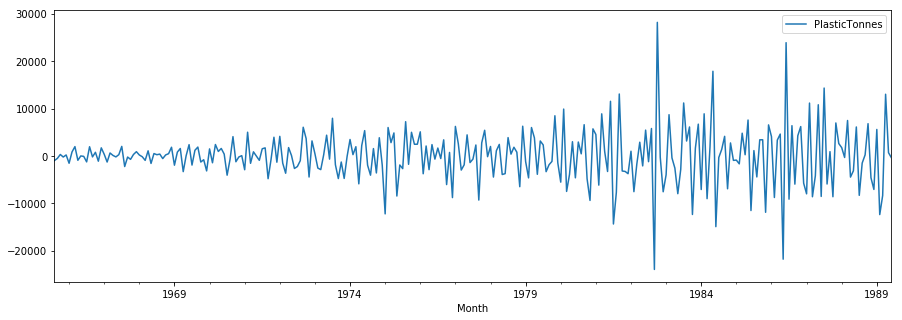

In [89]:
p = 1

plastic_ts_ts_sd365_fd1 = (plastic_ts_ts_sd365 - plastic_ts_ts_sd365.shift(p))[p:]
plastic_ts_ts_sd365_fd1.plot(figsize=(15,5))

In [90]:
print('KPSS statistics = {:.2f}'.format(sm.tsa.kpss(plastic_ts_ts_sd365_fd1.values.flatten())[0]))
print('KPSS p_value = {:.2f}'.format(sm.tsa.kpss(plastic_ts_ts_sd365_fd1.values.flatten())[1]))

KPSS statistics = 0.05
KPSS p_value = 0.10


In [91]:
print('ADF statistics = {:.2f}'.format(sm.tsa.adfuller(plastic_ts_ts_sd365_fd1.values.flatten())[0]))
print('ADF p_value = {:e}'.format(sm.tsa.adfuller(plastic_ts_ts_sd365_fd1.values.flatten())[1]))

ADF statistics = -6.69
ADF p_value = 4.178615e-09


* Now the Data is stationary.

## 4. ACF and PACF 

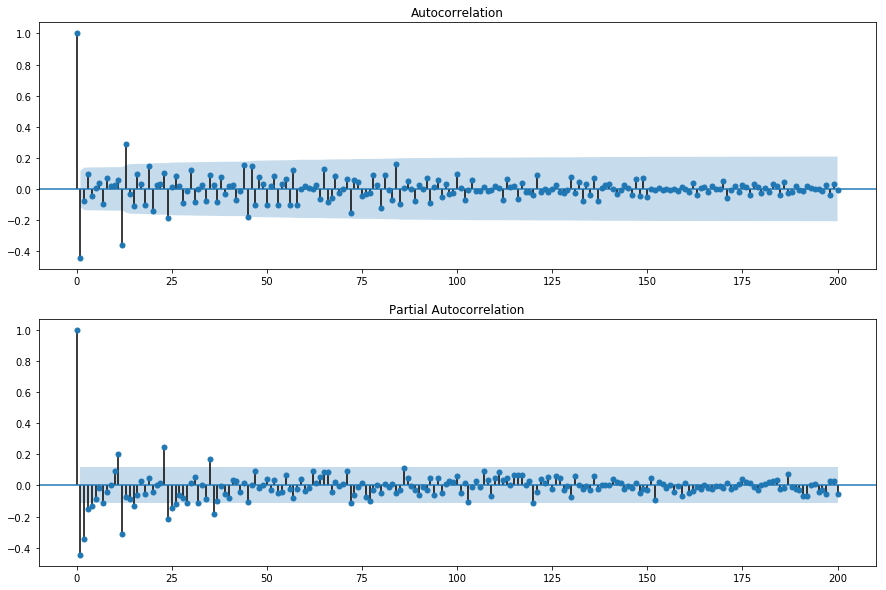

In [93]:
plt.clf()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.tsa.graphics.plot_acf(plastic_ts_ts_sd365_fd1.values.squeeze(),lags=200, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.tsa.graphics.plot_pacf(plastic_ts_ts_sd365_fd1.values.squeeze(),lags=200, ax=ax2)

* From this graphs we can not choose the p and the q.

## 5. Model selection and training

In [98]:
plastic_ts_train = plastic_ts[:'1987.01.01']
plastic_ts_test = plastic_ts['1987.01.01' :]

##### Search parameters:

In [99]:
grid_search_plastic_p = {'p':[1,12], 'd':[1], 'q':[1,2,3], 'P':[0,1,2], 'D':[0,1,2], 'Q':[0,1,2], 's':[12]}

#####  Grid search:

In [100]:
plastic_ts_search_data, plastic_min_aic_params, plastic_min_rmse_params = train_plotting_SARIMAX(parameters = grid_search_plastic_p, 
                                                                                        data = plastic_ts_train, 
                                                                                        plotting_frequency = np.nan,
                                                                                        independent_variables = None
                                                                                        )

In [101]:
plastic_ts_search_data.to_csv(path_or_buf='C:/Users/AM000110/Desktop/ML/TimeSeries/Practise & Lab/data/plastic-grid-search.csv')

######  Otpimal parameters for according to min of AIC:

In [103]:
print_optimal_result_SARIMAX(plastic_min_aic_params)

Optimal paramaters for model = SARIMAX are:
 optimal_p = 1 
 optimal_d = 1 
 optimal_q = 1 
 optimal_P = 0 
 optimal_D = 2 
 optimal_Q = 2 
 optimal_s = 12


[1, 1, 1, 0, 2, 2, 12, 4793.4511918535673, 3756.0019265508545]

######  Otpimal parameters for according to min of RMSE:

In [104]:
print_optimal_result_SARIMAX(plastic_min_rmse_params)

Optimal paramaters for model = SARIMAX are:
 optimal_p = 12 
 optimal_d = 1 
 optimal_q = 1 
 optimal_P = 2 
 optimal_D = 1 
 optimal_Q = 2 
 optimal_s = 12


[12, 1, 1, 2, 1, 2, 12, 4993.9501795018678, 3338.2264763548651]

######  Forecasting with these parameters:

In [105]:
plastic_ts_opt_frc_aic_train = optimal_forecast_SARIMAX(plastic_ts_train, plastic_ts_train, plastic_min_aic_params, False)
plastic_ts_opt_frc_rmse_train = optimal_forecast_SARIMAX(plastic_ts_train, plastic_ts_train, plastic_min_rmse_params, False)

plastic_ts_opt_frc_aic_test = optimal_forecast_SARIMAX(plastic_ts_train, plastic_ts_test, plastic_min_aic_params, True)
plastic_ts_opt_frc_rmse_test = optimal_forecast_SARIMAX(plastic_ts_train, plastic_ts_test, plastic_min_rmse_params, True)

######  Plotting forecasts with these parameters:

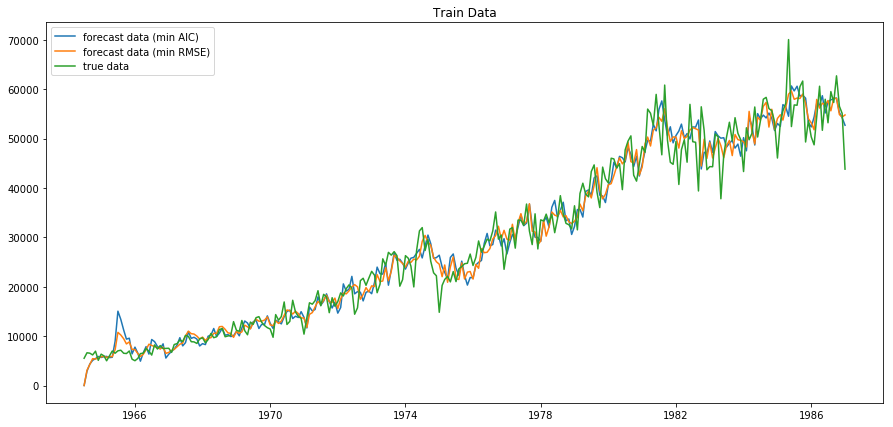

In [106]:
plt.clf()
plt.figure(figsize=(15,7))
plt.plot(plastic_ts_opt_frc_aic_train, label='forecast data (min AIC)')
plt.plot(plastic_ts_opt_frc_rmse_train, label='forecast data (min RMSE)')
plt.plot(plastic_ts_train, label='true data')
plt.title('Train Data')
plt.legend()

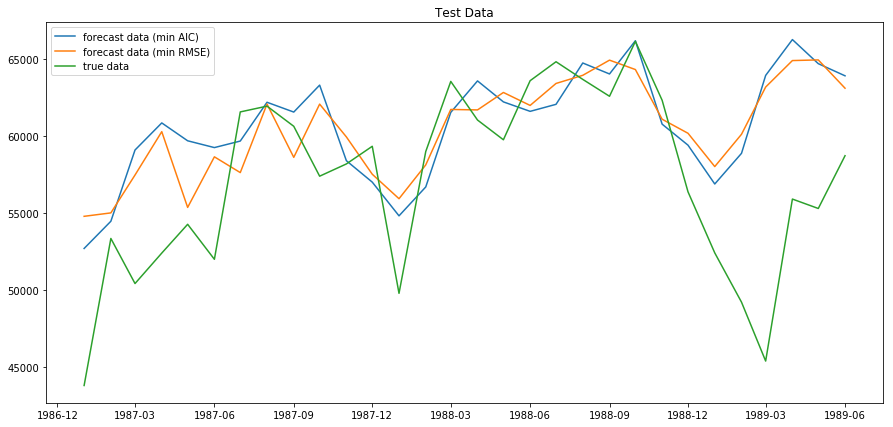

In [107]:
plt.clf()
plt.figure(figsize=(15,7))
plt.plot(plastic_ts_opt_frc_aic_test, label='forecast data (min AIC)')
plt.plot(plastic_ts_opt_frc_rmse_test, label='forecast data (min RMSE)')
plt.plot(plastic_ts_test, label='true data')
plt.title('Test Data')
plt.legend()

In [113]:
ix = range(len(plastic_ts_train.index))

plastic_train_min_aic_macape = qualityMACAPE(plastic_ts_opt_frc_aic_train.iloc[ix], plastic_ts_train.iloc[ix])[0]
plastic_train_min_rmse_macape = qualityMACAPE(plastic_ts_opt_frc_rmse_train.iloc[ix], plastic_ts_train.iloc[ix])[0]          

print('min AIC Train accuracy = {:.2f}%, min RMSE Train accuracy = {:.2f}%'.format(float(1-plastic_train_min_aic_macape.values)*100, 
                                                                     float(1-plastic_train_min_rmse_macape.values)*100))

min AIC Train accuracy = 88.09%, min RMSE Train accuracy = 89.44%


In [111]:
ix = range(len(plastic_ts_test.index))

plastic_test_min_aic_macape = qualityMACAPE(plastic_ts_opt_frc_aic_test.iloc[ix], plastic_ts_test.iloc[ix])[0]
plastic_test_min_rmse_macape = qualityMACAPE(plastic_ts_opt_frc_rmse_test.iloc[ix], plastic_ts_test.iloc[ix])[0]          

print('min AIC Test accuracy = {:.2f}%, min RMSE Test accuracy = {:.2f}%'.format(float(1-plastic_test_min_aic_macape.values)*100, 
                                                                     float(1-plastic_test_min_rmse_macape.values)*100))

min AIC Test accuracy = 92.06%, min RMSE Test accuracy= 92.21%


* as an optimal model parameters we will choose the rmse parameters

In [114]:
print_optimal_result_SARIMAX(plastic_min_rmse_params)

Optimal paramaters for model = SARIMAX are:
 optimal_p = 12 
 optimal_d = 1 
 optimal_q = 1 
 optimal_P = 2 
 optimal_D = 1 
 optimal_Q = 2 
 optimal_s = 12


[12, 1, 1, 2, 1, 2, 12, 4993.9501795018678, 3338.2264763548651]

## 6. Residual analysis

In [158]:
plastic_model = sm.tsa.SARIMAX(plastic_ts, order = (12,1,1), seasonal_order = (2,1,2,12), enforce_stationarity=False, enforce_invertibility=False)
plastic_model_results = plastic_model.fit()
plastic_residuals = plastic_model_results.resid
print(plastic_model_results.summary())

                                  Statespace Model Results                                 
Dep. Variable:                       PlasticTonnes   No. Observations:                  300
Model:             SARIMAX(12, 1, 1)x(2, 1, 2, 12)   Log Likelihood               -2429.470
Date:                             Wed, 14 Jun 2017   AIC                           4894.940
Time:                                     22:35:09   BIC                           4961.608
Sample:                                 07-01-1964   HQIC                          4921.621
                                      - 06-01-1989                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6224      0.910     -0.684      0.494      -2.406       1.162
ar.L2         -0.4768      

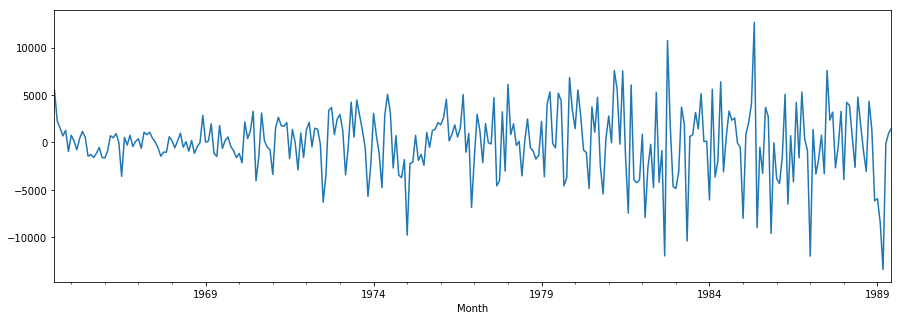

In [159]:
plastic_residuals.plot(figsize=(15,5))

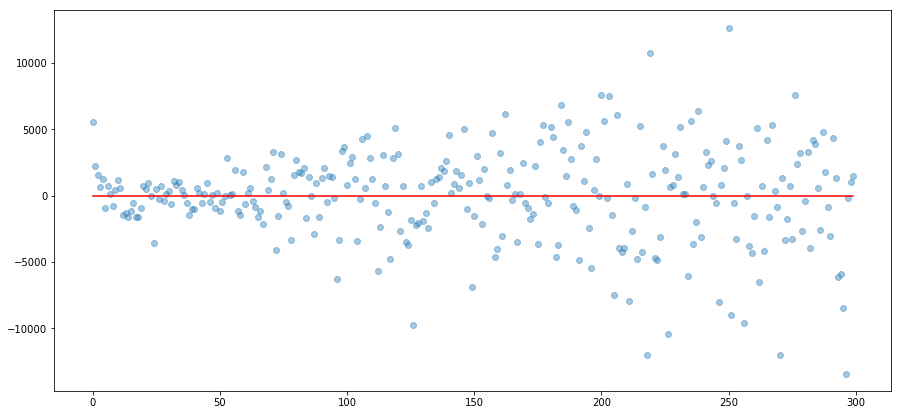

In [160]:
plt.figure(figsize=(15,7))
plt.scatter(range(plastic_residuals.index.size),plastic_residuals.values, alpha = 0.4)
plt.plot(range(plastic_residuals.index.size),[0]*(plastic_residuals.index.size), c = 'r' )

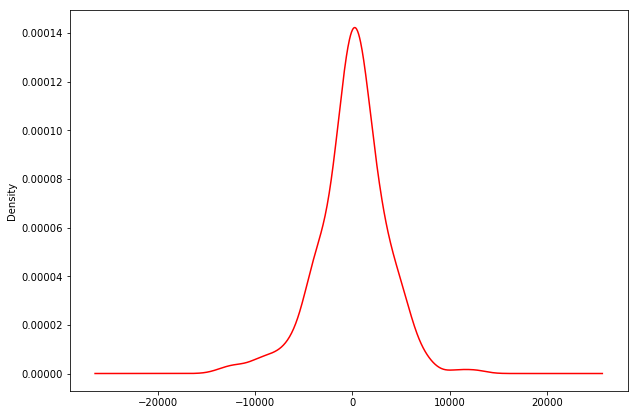

In [161]:
plastic_residuals.plot(kind = 'kde', c = 'r', figsize=(10,7))

##### 6.1 Unbiased test (Wilcoxon statistics (null hypothesis = unbiasedness))

In [162]:
print('p-value = {:.2f}'.format(scipy.stats.wilcoxon(plastic_residuals)[1]))
print('mean = {:.2f}'.format(plastic_residuals.mean()))

p-value = 0.50
mean = -19.74


##### 6.2 Stationarity test (KPSS  statistics (null hypothesis = stionarity)) 

In [163]:
print('KPSS statistics = {:.2f}'.format(sm.tsa.kpss(plastic_residuals.values.flatten())[0]))
print('KPSS p_value = {:.2f}'.format(sm.tsa.kpss(plastic_residuals.values.flatten())[1]))

KPSS statistics = 0.16
KPSS p_value = 0.10


##### 6.3 Correlation test (Durbin - Watson statistics (null hypothesis = no serial correlation, should be = 2)) 

In [164]:
print('Durbin - Watson statistics = {:.2f}'.format(sm.stats.durbin_watson(plastic_residuals.values)))

Durbin - Watson statistics = 1.97


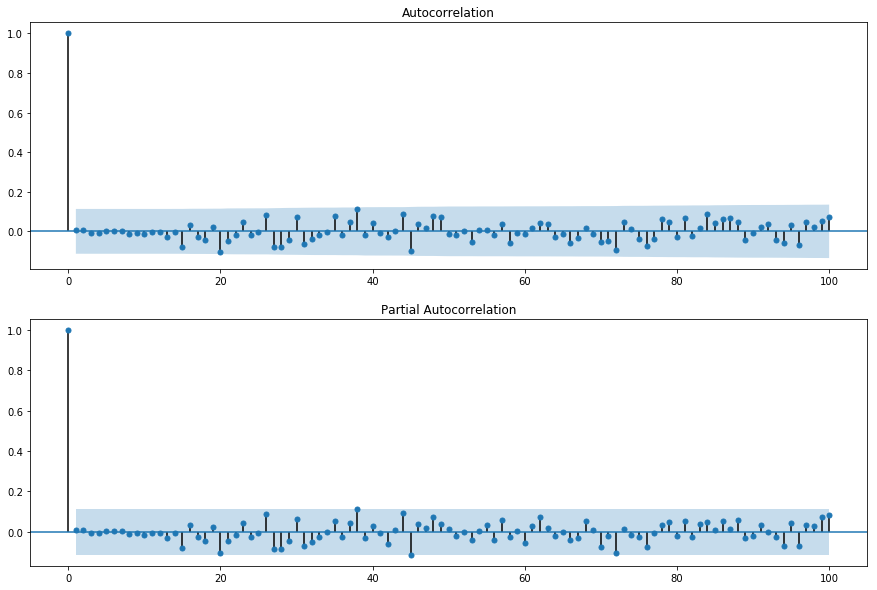

In [165]:
plt.clf()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.tsa.graphics.plot_acf(plastic_residuals.values.squeeze(),lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.tsa.graphics.plot_pacf(plastic_residuals.values.squeeze(),lags=100, ax=ax2)

##### 6.4 Normality test (Shapiro - Wilk statistics (null hypothesis = data is from Normal distribution)) 

In [166]:
print('Shapiro - Wilk p-value = {:.2f}'.format(scipy.stats.shapiro(plastic_residuals.values)[1]))

Shapiro - Wilk p-value = 0.00


#### Final result for Residuals
* they are unbiased
* they are stationary
* they are uncorrelated
* they are not from Normal distribution